# 【华泰金工】比乔斯基价值选股研报复现和延伸探讨

-- 本研报分析基于[【复现】FFScore财务模型](https://www.joinquant.com/view/community/detail/34748?type=1&page=1)，按照自己的理解，做了部分代码更新。

-- 更新部分，原版采用 alphalens 库做分析，但因为该库已经不再维护，为了确保后续分析稳定性，这里修改为聚宽的因子分析框架 jqfactor_analyzer()。但又因为 jqfactor_analyzer() 库非常耗内存，平台版本还是以 alaphalens 的输出为主。


# 1. 理论整理

## 1.1 比乔斯基选股模型

<font color='red'>**比乔斯基选股模型**</font>是斯坦福大学商学院教授约瑟夫·比乔斯基的基于市净率等历史财务数据为衡量标准的价值选股模型。

该选股模型在低市净率选股的基础上，通过代表盈利水平、财务杠杆及流动性和运营效率的9个财务指标对股票进行优劣筛选，简称 Fscore。

- **底层逻辑**

    比乔斯基认为，购买低市净率的上市公司股票，即股价和每股净资产比值相对低的股票是具有安全边际的。
    
    美股中低市净率股票的上市公司更容易陷入财务困境直至破产和退市，于是考虑通过上市公司财务报表分析方法来避免低市净率的投资陷阱。
    
    他在自己的经典论文《Value Investing: The Use of Historical Financial Statement Information to Separate Winners from Losers》就提出并验证了 FScore 财务分析方法在美国股票市场可以显著提高低市净率股票组合收益率。
    
    比乔斯基模型选用了代表盈利水平、财务杠杆及流动性和运营效率的 9 个财务指标对股票进行优劣筛选。这三个领域共九个指标分别采用 0-1 度量（即参数为 1 或者 0），使得股票的得分为 0 至 9 分。分数越高时，代表该股票的投资价值越高。


- **本文研究思路**

    从逻辑上看，低市净率确实是一个有效的选股因子。华泰研报对市净率的分层结果可以看出，在剔除负市净率之后，低市净率组在收益表现上好于高市净率组，这里做最新实证。
    
    比乔斯基在低市净率的基础上，加入了关键 9 财务指标作为选股条件后，模型表现较低市净率策略有着显著提高，其论文也证明了该分析方法是稳健可靠的，这里做实证。

    华泰根据比乔斯基的选股方法，在 A 股市场进行了实证研究发现，原始模型和增强的模型在 A 股市场效果并没有那么显著，并提出了改进的华泰5财务指标模型：FFScore，这里做实证。
    
    基于比乔斯基和华泰的分析思路，本文尝试建立一个基于财务指标的因子组合优化流程，借助比乔斯基的打分思路，尝试够建一个新的改进因子，并做实证分析。


## 1.2 比乔斯基模型设计解构

- **盈利水平**

    一家企业的收益率与现金流指标展现了一家企业累积资本的能力，所以代表盈利水平的指标为：资产收益率($ROA$)、经营现金流量($CFO$)、资产收益率变化($\Delta ROA$)、与自然增长性($ACCRUAL$)。
    
    比乔斯基也提到低市净率的上市公司有历史收益不佳的问题，如果在最新财报期能够看到盈利能力并呈现现金净流入，即收益增长趋势，则可以说明这家公司开始具备改善未来盈利水平的能力。    
    
    此外，自然增长性表现了收益与现金流的关系，如果现金的流入能够超越收益，则说明了企业在未来的增长有更好的基础。

    - 资产收益率($ROA$：$\frac{净利润*2}{期初总资产+期末总资产}$)，原本使用的$\frac{EBIT* 2}{期初总资产 + 期末总资产}$)，为正则为1否则为0； 
    
    - 经营现金流量($CFO$：$\frac{经营活动产生的现金流量净额}{资产总值}$)，为正则为1否则为0； 
    
    - 资产收益率同比($\Delta ROA$)，增加为正则为1否则为0；
    
    - 收益自然增长率($ACCRUAL$：$CFO - ROA$)，为正则为1否则为0；


- **财务杠杆和流动性**
    
    低市净率的公司往往面临着财务困境，所以通常会有着杠杆偏高，流动性偏弱，以及需要通过增资扩股来进行外部融资的需求；
    
    可以将杠杆的减少、流动性的增强，以及没有扩充股权的需求来作为一家企业在财务困境方面是否有好转的信号；
    
    代表了财务杠杆及流动性的指标为杠杆变化($\Delta LEVER$)、流动性变化($\Delta LIQUID$)）、与是否发行普通股权(EQ_OFFER)。

    - 长期资产负债率同比($\Delta LEVER$)减少，为负时为1否则为0；
    
    - 流动比率同比($\Delta LIQUID$)增加，正则为1否则为0；
    
    - 股本等于或者小于同比的股本($EQ_OFFER$)，正则为1否则为0；


- **运营效率**

    毛利润的增加意味着公司的成本降低或者产品售价提高，资产周转率增加则反映了公司运营周转效率的提升
    
    因此，这两个指标有效的表示了企业在运营方面的能力提高，从而为其未来生存竞争力与公司的成长提供有力的支持；
    
    代表了运营效率的指标为毛利润率变化($\Delta MARGIN$)与资产周转率变化($\Delta TURN$)

    - 毛利率同比增加($\Delta MARGIN$)，正则为1否则为0；
    
    - 资产周转率同比增加($\Delta TURN$)，正则为1否则为0


- **FScore原始模型**
    
    以上九个参数之和，反应企业整体投资价值的信号:
    
    $FScore = ROA + CFO + \Delta ROA + ACCRUAL + \Delta LEVER + \Delta LIQUID + EQ_OFFER + \Delta MARGIN + \Delta TURN $

## 1.3 华泰提出的A股增强选股模型 FFScore

A 股市场相对于美国市场的波动更高、以及 9 个财务指标来进行筛选高分股票数量偏少导致的投资收益的风险增大的原因，同时可能还由于财务报告编制方法、中美财务指标的计算原则、以及 A 股市场投资者对财务指标变化的理解有所不同

华泰尝试进一步优化原有的比乔斯基模型，并叠加低市净率指标，经过测试提出了更适合中国 A 股市场的华泰 Five FScore（FFScore）低市净率选股模型。（这里务必注意，所有的数据为同比变化，故调仓周期不可小于季度）

- **盈利水平**

    在体现盈利水平方面上，选取了 ROE 指标（$ROE = \frac{归属母公司股东净利润}{年平均归属母公司股东的权益}$），即衡量每份股东权益所产生的盈利，而非每份资产所产生的盈利。这样能够更好的诠释公司为股东创造的价值，通过盈利能力驱动股价上涨。

    - 资产收益率（$ROE$），<font color='red'>收益率</font>为正数时ROE=1，否则为0
    
    - 资产收益率变化（$\Delta ROA$），当期最新可得财务报告的<font color='red'>ROA同比</font>的变化，变化为正数时为1，否则为0


- **财务杠杆和流动性**

    比乔斯基选取了 $\Delta LEVER$ 代表盈利水平，是因为 $\Delta LEVER$ 指标是由长期负债与长期资产两部分构成，能够相对较好的减轻短期市场波动带来的影响，从更大程度上反应一家上市企业自己经营与发展方面的财务情况。这一点在波动较大的A 股市场适用

    - 杠杆变化（ $\Delta LEVER$ ），杠杆 $LEVER = \frac{非流动负债合计}{非流动资产合计}$，杠杆变化为当期最新可得财务报告的<font color='red'>杠杆同比</font>的变化，变化为负数时△LEVER=1，否则为0


- **运营效率**

    从财务分析的角度考虑，销售毛利率增量（ $\Delta MARGIN = \frac{毛利润}{营业收入}$），与 $\Delta ROE$ 指标的选取要素净利润类似，均含有利润相关的指标，一定程度上和盈利水平指标重复。
    
    华泰分析认为 $\Delta MARGIN$ 与 $\Delta ROA$ 指标的相关度达到了0.64892，在使用单个指标时效果优异，组合后的效果并不明显，所以做了筛选。
    
    类似的，华泰选取净利率（$\Delta NETMARGIN$）后发现，组合的效果并不理想，因此选择加入了流动资产周转率变化（$\Delta CATURN = \frac{主营业务收入}{流动资产}$）指标，来反映流动资产的周转速度，衡量企业在生产运营上对流动资产的利用效率。

    华泰实证后发现，$\Delta CATURN$ 与 $\Delta TURN = \frac{总资产周转率}{平均资产总值}$ 能更好的单独筛选出运营效率好的上市公司，避免了盈利水平指标的影响，所以选取流动资产周转率变化（$\Delta CATURN$）与资产周转率变化（$\Delta TURN$）代表运营效率。

    - 流动资产周转率变化（$\Delta CATURN$），流动资产周转率变化为当期最新可得财务报告的<font color='red'>资产周转率同比</font>的变化，变化为正数时为1，否则为0
    
    - 资产周转率变化（$\Delta TURN$），资产周转率变化为当期最新可得财务报告的<font color='red'>资产周转率同比</font>的变化，变化为正数时为1，否则为0。


- **华泰 FFScore 模型**
    
    FFScore为以上五个参数之和，反应企业整体投资价值的信号:
    
    $FFScore = ROE + \Delta ROE + \Delta CATURN + \Delta TURN + \Delta LEVER$

# 2. 研究准备

## 2.1 依赖库和固化的方法

In [1]:
from typing import (List,Tuple,Dict,Callable,Union)
from IPython.core.display import display, HTML

import datetime as dt
import numpy as np
import pandas as pd
import empyrical as ep
import pickle

import graphviz
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

from tqdm import tqdm_notebook

import alphalens as al

from jqdata import *
from jqfactor import calc_factors, Factor, analyze_factor

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

display(HTML("<style>.container { width:100% !important; }</style>"))  # Juypter 的显示调整
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [182]:
"""封装的 jqdata 数据处理"""
# 获取行业
def get_stock_ind(securities:list, 
                  watch_date:str, 
                  level:str='sw_l1', 
                  method:str='industry_code'
                 )->pd.Series:
    
    '''
    获取行业
    --------
        securities:股票列表
        watch_date:查询日期
        level:查询股票所属行业级别
        method:返回行业名称or代码
    '''
    # 查询股票所属行业，返回一个dict， key是标的代码，值是各行业信息
    indusrty_dict = get_industry(securities, watch_date)
    
    """这句非常优雅，点赞!!"""
    # get()函数，返回 level 关键词对应的值，然后提取次级中 method 的值，如果没有值，返回 np.nan
    # 如从 industry_dict 中查找每只股票的 level=sw_l1 的信息，返回其 method=industry_code 的值，如 '银行I'
    indusrty_ser = pd.Series({k: v.get(level, {method: np.nan})[method] for k, v in indusrty_dict.items()})
    
    indusrty_ser.name = method.upper()
    
    return indusrty_ser

# 获取股价
def get_factor_price(security: Union[List, str],
                     periods: List
                    ) -> pd.DataFrame:
    '''获取对应频率的收盘价'''
    for trade in tqdm_notebook(periods, desc='获取收盘价数据'):

        yield get_price(security,
                        end_date=trade,
                        count=1,
                        fields='close',
                        fq = 'post',  # 后复权
                        panel=False)

# 获取市净率
def get_factor_pb_ratio(securities: Union[list, str],
                        periods: list
                       ) -> pd.DataFrame:
    '''获取PB数据'''
    for trade in tqdm_notebook(periods, desc='获取PB数据'):

        yield get_valuation(securities,
                            end_date=trade,
                            fields=['pb_ratio'],
                            count=1)
        
"""风险指标计算"""
def Strategy_performance(return_df: pd.DataFrame,
                         periods='daily',
                         benchmark=None
                        ) -> pd.DataFrame:
    '''计算风险指标 默认为月度:月度调仓'''

    ser: pd.DataFrame = pd.DataFrame()
    ser['年化收益率'] = ep.annual_return(return_df, period=periods)
    ser['累计收益'] = ep.cum_returns(return_df).iloc[-1]
    ser['波动率'] = return_df.apply(lambda x: ep.annual_volatility(x, period=periods))
    ser['夏普'] = return_df.apply(ep.sharpe_ratio, period=periods)
    ser['最大回撤'] = return_df.apply(lambda x: ep.max_drawdown(x))
    
    if benchmark:
        select_col = [col for col in return_df.columns if col != benchmark]
        ser['IR'] = return_df[select_col].apply(lambda x: information_ratio(x, return_df[benchmark]))
        ser['Alpha'] = return_df[select_col].apply(lambda x: ep.alpha(x, return_df[benchmark], period=periods))
        ser['超额收益'] = ser['年化收益率'] - ser.loc[benchmark, '年化收益率']  #计算相对年化波动率
        
    return ser.T

def information_ratio(returns, 
                      factor_returns):
    """
    Determines the Information ratio of a strategy.

    Parameters
    ----------
    returns : :py:class:`pandas.Series` or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        See full explanation in :func:`~empyrical.stats.cum_returns`.
    factor_returns: :class:`float` / :py:class:`pandas.Series`
        Benchmark return to compare returns against.

    Returns
    -------
    :class:`float`
        The information ratio.

    Note
    -----
    See https://en.wikipedia.org/wiki/information_ratio for more details.

    """
    if len(returns) < 2:
        return np.nan

    active_return = _adjust_returns(returns, factor_returns)
    tracking_error = np.std(active_return, ddof=1)
    if np.isnan(tracking_error):
        return 0.0
    if tracking_error == 0:
        return np.nan
    return np.mean(active_return) / tracking_error

def _adjust_returns(returns, 
                    adjustment_factor):
    """
    Returns a new :py:class:`pandas.Series` adjusted by adjustment_factor.
    Optimizes for the case of adjustment_factor being 0.

    Parameters
    ----------
    returns : :py:class:`pandas.Series`
    adjustment_factor : :py:class:`pandas.Series` / :class:`float`

    Returns
    -------
    :py:class:`pandas.Series`
    """
    if isinstance(adjustment_factor, (float, int)) and adjustment_factor == 0:
        return returns.copy()
    return returns - adjustment_factor

"""因子合成"""
# 标记得分
def sign(ser: pd.Series
        ) -> pd.Series:
    '''标记分数,正数为1,负数为0'''
    
    return ser.apply(lambda x: np.where(x > 0, 1, 0))

# 因子构造器
class FScore(Factor):
    '''
    FScore原始模型
    '''
    name = 'FScore'
    # 获取数据的最长时间窗口，返回的是日级别的数据，需要使用 pd.DataFrame 转换
    max_window = 1
    watch_date = None
    # paidin_capital 实收资本 股本变化会反应在该科目中
    # 依赖的基础因子名称 https://www.joinquant.com/help/api/help#factor_values:%E5%9B%A0%E5%AD%90%E5%88%97%E8%A1%A8
    dependencies = [
        'roa', 'roa_4', 'net_operate_cash_flow', 'total_assets',
        'total_assets_1', 'total_assets_4', 'total_assets_5',
        'operating_revenue', 'operating_revenue_4',
        'total_non_current_assets', 'total_non_current_liability',
        'total_non_current_assets_4', 'total_non_current_liability_4',
        'total_current_assets', 'total_current_liability',
        'total_current_assets_4', 'total_current_liability_4',
        'gross_profit_margin', 'gross_profit_margin_4', 'paidin_capital',
        'paidin_capital_4'
    ]

    def calc(self, data: Dict) -> None:

        roa: pd.DataFrame = data['roa']

        cfo: pd.DataFrame = data['net_operate_cash_flow'] / data['total_assets']

        delta_roa: pd.DataFrame = roa / data['roa_4'] - 1

        accrual: pd.DataFrame = cfo - roa * 0.01

        # 杠杆变化
        ## 变化为负数时为1，否则为0 取相反
        leveler: pd.DataFrame = data['total_non_current_liability'] / data['total_non_current_assets']
        leveler1: pd.DataFrame = data['total_non_current_liability_4'] / data['total_non_current_assets_4']
        delta_leveler: pd.DataFrame = -(leveler / leveler1 - 1)

        # 流动性变化
        liquid: pd.DataFrame = data['total_current_assets'] / data['total_current_liability']
        liquid_1: pd.DataFrame = data['total_current_assets_4'] / data['total_current_liability_4']
        delta_liquid: pd.DataFrame = liquid / liquid_1 - 1

        # 毛利率变化
        delta_margin: pd.DataFrame = data['gross_profit_margin'] / data['gross_profit_margin_4'] - 1

        # 是否发行普通股权
        eq_offser: pd.DataFrame = data['paidin_capital'] / data['paidin_capital_4'] - 1

        # 总资产周转率
        total_asset_turnover_rate: pd.DataFrame = data['operating_revenue'] / (data['total_assets'] + data['total_assets_1']).mean()

        total_asset_turnover_rate_1: pd.DataFrame = data['operating_revenue_4'] / (data['total_assets_4'] + data['total_assets_5']).mean()

        # 总资产周转率同比
        delta_turn: pd.DataFrame = total_asset_turnover_rate / total_asset_turnover_rate_1 - 1

        indicator_tuple: Tuple = (roa, cfo, delta_roa, accrual, delta_leveler, delta_liquid, delta_margin, delta_turn, eq_offser)

        # 储存计算FFscore所需原始数据
        self.basic: pd.DataFrame = pd.concat(indicator_tuple).T.replace([-np.inf, np.inf], np.nan)
        #
        self.basic.columns = ['ROA', 'CFO', 'DELTA_ROA', 'ACCRUAL', 'DELTA_LEVELER', 'DLTA_LIQUID', 'DELTA_MARGIN', 'DELTA_TURN', 'EQ_OFFSER']
        self.fscore: pd.Series = self.basic.apply(sign).sum(axis=1)

class FFScore(Factor):
    name = 'FFScore'
    max_window = 1
    watch_date = None

    dependencies = [
        'roe', 'roe_4', 'total_assets', 'total_assets_1', 'total_assets_4',
        'total_assets_5', 'operating_revenue', 'operating_revenue_4',
        'total_non_current_assets', 'total_non_current_assets_4',
        'total_non_current_liability', 'total_non_current_liability_4',
        'total_current_assets', 'total_current_assets_1',
        'total_current_assets_4', 'total_current_assets_5',
        'total_operating_revenue', 'total_operating_revenue_4'
    ]

    def calc(self, data: Dict) -> None:

        roe: pd.DataFrame = data['roe']

        delta_roe: pd.DataFrame = roe / data['roe_4'] - 1

        # 杠杆变化
        ## 变化为负数时为1，否则为0 取相反
        lever: pd.DataFrame = data['total_non_current_liability'] / data['total_non_current_assets']
        lever1: pd.DataFrame = data['total_non_current_liability_4'] / data['total_non_current_assets_4']
        delta_lever: pd.DataFrame = -(lever / lever1 - 1)

        # 流动资产周转率
        caturn_1 = data['operating_revenue'] / (data['total_current_assets'] + data['total_current_assets_1']).mean()
        caturn_2 = data['operating_revenue_4'] / (data['total_current_assets_4'] + data['total_current_assets_5']).mean()
        
        # 流动资产周转率同比
        delata_caturn = caturn_1 / caturn_2 - 1

        # 总资产周转率
        total_asset_turnover_rate: pd.DataFrame = data['total_operating_revenue'] / (data['total_assets'] + data['total_assets_1']).mean()
        total_asset_turnover_rate_1: pd.DataFrame = data['total_operating_revenue_4'] / (data['total_assets_4'] + data['total_assets_5']).mean()

        # 总资产周转率同比
        delta_turn: pd.DataFrame = total_asset_turnover_rate / total_asset_turnover_rate_1 - 1
        
        indicator_tuple: Tuple = (roe, delta_roe, delata_caturn, delta_turn, delta_lever)

        # 储存计算FFscore所需原始数据
        self.basic: pd.DataFrame = pd.concat(indicator_tuple).T.replace([-np.inf,np.inf],np.nan)
        #
        self.basic.columns = ['ROE', 'DELTA_ROE', 'DELTA_CATURN', 'DELTA_TURN', 'DELTA_LEVER' ]
        self.ffscore: pd.Series = self.basic.apply(sign).sum(axis=1)

class F13_Score(Factor):
    '''获取FScore及FFScore中提到的因子'''
    name = 'F13_Score'
    max_window = 1
    watch_date = None
    
    dependencies = [
        'roa', 'roa_4', 'net_operate_cash_flow', 'total_assets',
        'total_assets_1', 'total_assets_4', 'total_assets_5',
        'operating_revenue', 'operating_revenue_4','pb_ratio',
        'total_current_assets','total_current_assets_1','total_current_assets_4','total_current_assets_5',
        'total_non_current_assets', 'total_non_current_liability',
        'total_non_current_assets_4', 'total_non_current_liability_4',
        'total_current_assets', 'total_current_liability',
        'total_current_assets_4', 'total_current_liability_4',
        'gross_profit_margin', 'gross_profit_margin_4', 'paidin_capital',
        'paidin_capital_4','roe', 'roe_4','total_profit','total_profit_4','financial_expense','financial_expense_4'
    ]
    
    def calc(self, data: dict) -> None:
        
        roe: pd.DataFrame = data['roe']
        
        roa1: pd.DataFrame = data['roa'] # 单位为百分号
        
        # 息税前利润（EBIT）除以资产总值
        # 利息支出项大多数情况时缺失的所以这里用财务费用代替
        roa2 = (data['total_profit'] + data['financial_expense']) / (data['total_current_assets'] + data['total_current_assets_1']).mean()
        
        roa2_4 = (data['total_profit_4'] + data['financial_expense_4']) / (data['total_current_assets_4'] + data['total_current_assets_5']).mean()
        
        delta_roa2 = roa2 / roa2_4 - 1
        
        cfo: pd.DataFrame = data['net_operate_cash_flow'] / data['total_assets']

        delta_roa1: pd.DataFrame = roa1 / data['roa_4'] - 1
        
        delta_roe: pd.DataFrame = roe / data['roe_4'] - 1
            
        accrual: pd.DataFrame = cfo - roa1 * 0.01

        # 杠杆变化
        ## 变化为负数时为1，否则为0 取相反
        leveler: pd.DataFrame = data['total_non_current_liability'] / data['total_non_current_assets']
        leveler1: pd.DataFrame = data['total_non_current_liability_4'] / data['total_non_current_assets_4']
        delta_leveler: pd.DataFrame = -(leveler / leveler1 - 1)

        # 流动性变化
        liquid: pd.DataFrame = data['total_current_assets'] / data['total_current_liability']
        liquid_1: pd.DataFrame = data['total_current_assets_4'] / data['total_current_liability_4']
        delta_liquid: pd.DataFrame = liquid / liquid_1 - 1

        # 毛利率变化
        delta_margin: pd.DataFrame = data['gross_profit_margin'] / data['gross_profit_margin_4'] - 1

        # 是否发行普通股权
        eq_offser: pd.DataFrame = data['paidin_capital'] / data['paidin_capital_4'] - 1
        
        # 流动资产周转率
        caturn_1 = data['operating_revenue'] / (data['total_current_assets'] + data['total_current_assets_1']).mean()
        caturn_2 = data['operating_revenue_4'] / (data['total_current_assets_4'] + data['total_current_assets_5']).mean()
        # 流动资产周转率同比
        delata_caturn = caturn_1 / caturn_2 - 1
        
        # 总资产周转率
        total_asset_turnover_rate: pd.DataFrame = data['operating_revenue'] / (data['total_assets'] + data['total_assets_1']).mean()
        total_asset_turnover_rate_1: pd.DataFrame = data['operating_revenue_4'] / (data['total_assets_4'] + data['total_assets_5']).mean()

        # 总资产周转率同比
        delta_turn: pd.DataFrame = total_asset_turnover_rate / total_asset_turnover_rate_1 - 1
        
        indicator_tuple: Tuple = (roe, delta_roe,roa1,delta_roa1,roa2,delta_roa2, accrual, delta_leveler, delta_liquid, delta_margin,eq_offser,delata_caturn, delta_turn, data['pb_ratio'])

        # 储存计算 New FScore 所需原始数据
        self.basic: pd.DataFrame = pd.concat(indicator_tuple).T.replace([-np.inf,np.inf],np.nan)
        #
        self.basic.columns = ['ROE', 'DELTA_ROE','ROA1','DELTA_ROA1','ROA2','DELTA_ROA2','ACCRUAL', 'DELTA_LEVER', 'DLTA_LIQUID', 'DELTA_MARGIN', 'EQ_OFFSER', 'DELTA_CATURN', 'DELTA_TURN','PB_RATIO']
        self.F13_Score: pd.Series = self.basic.apply(sign).sum(axis=1)

# 因子获取
def get_FScore(symbol: str, 
               factor: Factor, 
               periods: List, 
               filter_industry: Union[List, str] = None
              ) -> Tuple[pd.Series, pd.DataFrame]:
    '''
    获取FScore得分
    ------
    输入参数：
        symbol:输入A表示全A股票池或者输入指数代码
        factor:不同的fscore模型
        periods:计算得分的时间序列
        filter_industry:传入需要过滤的行业
    ------
    return 最终得分, 财务数据
    '''
    for trade in tqdm_notebook(periods, desc=str(factor)+'因子获取'):

        # 获取股票池
        stock_pool_func = Filter_Stocks(symbol, trade)
        stock_pool_func.filter_paused(22, 21)  # 过滤22日停牌超过21日的股票
        stock_pool_func.filter_st()  # 过滤st
        stock_pool_func.filter_ipodate(180)  # 过滤次新
        
        # 是否过滤行业
        if filter_industry:
            stock_pool_func.filter_industry(filter_industry)
        my_factor = factor()
        my_factor.watch_date = trade
        
        # 因子计算
        # 返回一个 dict 对象, key 是各 factors 的 name，value 是一个DataFrame，index 是日期， column 是股票代码
        calc_factors(stock_pool_func.securities, [my_factor], start_date=trade, end_date=trade)
        # 使用生成器，返回因子值
        yield my_factor


"""通用方法"""
# 获取年末季末时点
def get_trade_period(start_date: str, 
                     end_date: str, 
                     freq: str = 'ME'
                    ) -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月，Q季,Y年 默认ME E代表期末 S代表期初
    ================
    return  list[datetime.date]
    '''
    days = pd.Index(pd.to_datetime(get_trade_days(start_date, end_date)))
    idx_df = days.to_frame()

    if freq[-1] == 'E':
        day_range = idx_df.resample(freq[0]).last()
    else:
        day_range = idx_df.resample(freq[0]).first()

    day_range = day_range[0].dt.date

    return day_range.dropna().values.tolist()

# 筛选股票池
class Filter_Stocks(object):
    '''
    这是一个可通用的类，用于获取某日的成分股股票
    1. 过滤st
    2. 过滤上市不足N个月
    3. 过滤当月交易不超过N日的股票
    ---------------
    输入参数：
        index_symbol:指数代码,A等于全市场,
        watch_date:日期
    '''
    
    def __init__(self,symbol:str,watch_date:str)->None:
        
        if isinstance(watch_date,str):
            
            self.watch_date = pd.to_datetime(watch_date).date()
            
        else:
            
            self.watch_date = watch_date
            
        self.symbol = symbol
        self.get_index_component_stocks()
        
    def get_index_component_stocks(self)->list:
        
        '''获取指数成分股'''
        
        if self.symbol == 'A':
            # 返回当日所有的股票列表，但不判断是否可交易
            wd:pd.DataFrame = get_all_securities(types=['stock'],date=self.watch_date)
            self.securities:List = wd.query('end_date != "2200-01-01"').index.tolist()
        else:
            # 取该指数的成分股
            self.securities:List = get_index_stocks(self.symbol,self.watch_date)
    
    def filter_paused(self,paused_N:int=1,threshold:int=None)->list:
        
        '''过滤停牌股
        -----
        输入:
            paused_N:默认为1即查询当日不停牌
            threshold:在过paused_N日内停牌数量小于threshold
            如果希望区间内完全没有停牌股票， paused_N 应等于 threshold
        '''
        
        if (threshold is not None) and (threshold > paused_N):
            raise ValueError(f'参数threshold天数不能大于paused_N天数')
            
        # 将基于查询时点 watch_date 向前推 paused_N 个交易日的数据，取停牌字段，重组为透视表，停牌为1
        paused = get_price(self.securities,end_date=self.watch_date,count=paused_N,fields='paused',panel=False)
        paused = paused.pivot(index='time',columns='code')['paused']
        
        # 如果threhold不为None 获取过去paused_N内停牌数少于threshodl天数的股票
        if threshold:
            # 求和后，sum_paused_day 的值为时间区间内停牌的次数，如停牌2次，则该值为2
            sum_paused_day = paused.sum()
            # 取出所有停牌次数少于 threshold 的股票，存为列表
            self.securities = sum_paused_day[sum_paused_day < threshold].index.tolist()
        
        else:
            # 如果不指定阈值，则返回最新一日未停牌的股票列表
            paused_ser = paused.iloc[-1]
            self.securities = paused_ser[paused_ser == 0].index.tolist()
    
    def filter_st(self)->list:
        
        '''过滤ST'''
        # get_extras API 可直接返回当日是否为 ST 的结果，是为 True  
        extras_ser = get_extras('is_st',self.securities,end_date=self.watch_date,count=1).iloc[-1]
        # 返回当日不是 ST 的列表
        self.securities = extras_ser[extras_ser == False].index.tolist()
    
    def filter_ipodate(self,threshold:int=180)->list:
        
        '''
        过滤上市天数不足以threshold天的股票
        -----
        输入：
            threhold:默认为180日
        '''
        
        def _check_ipodate(code:str,watch_date:dt.date)->bool:
            # 检查上市至今的日期是否大于阈值，是为 True
            code_info = get_security_info(code)
            
            if (code_info is not None) and ((watch_date - code_info.start_date).days > threshold):
                
                return True
            
            else:
                
                return False
        # 如果大于阈值则纳入代码表
        self.securities = [code for code in self.securities if _check_ipodate(code,self.watch_date)]
    
    def filter_industry(self,industry:Union[List,str],level:str='sw_l1',method:str='industry_name')->list:
        '''过滤行业'''
        ind = get_stock_ind(self.securities,self.watch_date,level,method)
        target = ind.to_frame('industry').query('industry != @industry')
        self.securities = target.index.tolist()

# 数据存储
def pkl_batch(file=None, 
              file_name=None, 
              method=None):
    """
    将数据保存为 pkl 格式，或者读取
    --------
    输入参数：
        file：用于存储的数据
        file_name：pkl 文件名
        method：传入是写入还是读取
    --------
    return 
    """
    if method == 'write':
        pickle_file = open(file_name+'.pkl', 'wb')
        pickle.dump(file, pickle_file)
        pickle_file.close()
        return True
    elif method == 'read':
        pickle_file = open(file_name+'.pkl', 'rb')
        data = pickle.load(pickle_file)
        pickle_file.close()
        return data
    else:
        return False
    
"""绘图函数"""
# 绘制各分组的累计收益统计图
def plot_cum_return(title=None, 
                    ret=None, 
                    benchmark_ret=None, 
                    benchmark_name=None):
    """
    绘制各分组的累计收益图
    --------
    title：图表标题
    ret：分组的收益率 df 格式文件
    benchmark_ret：基准的收益率 df 格式文件
    benchmark_name：基准名称
    --------
    return 绘图
    """
    fig, ax = plt.subplots(figsize=(26, 6))
    ax.set_title(title)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x * 100)))
    ep.cum_returns(ret).plot(ax=ax,color=color_map)
    if not benchmark_ret.empty:
        ep.cum_returns(benchmark_ret.reindex(ret.index)).plot(ax=ax, label=benchmark_name, color='darkgray', ls='--')
    ax.axhline(0, color='black', lw=1)
    plt.legend()
    
def plot_heatmap(df=None, 
                 title=None):
    """
    绘制相关性的热力图
    -------
    df：需要绘制的 df 格式文件
    title：标题
    -------
    return 绘图
    """
    fig, ax = plt.subplots(figsize=(26, 6))
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax.set_title(title)
    sns.heatmap(corr, annot = True, linewidths=.5, mask=mask)

## 2.2 设置全局参数

In [3]:
# 时间区间
# startDt, endDt = '2022-01-01', '2022-05-01'  # for test
startDt, endDt = '2014-01-01', '2022-05-01'

# 每月初的日期列表，用于获取因子
periods: List = get_trade_period(startDt, endDt, 'M')
    
# 价格时间范围，用于价格计算，适当比因子数据早几年
startDt, endDt = '2010-01-01', '2022-05-01'
price_periods = get_trade_period(startDt, endDt, 'M')

# 其他全局参数
color_map = ['red', 'green', 'cyan', 'magenta', 'blue']

# 3. FScore 财务模型因子分析

比乔斯基在其 Fscore 模型中采取的打分机制，所以因子不需要进行去极值和标准化步骤。

## 3.1 基础数据获得

In [108]:
# 获取FFScore得分，每个都是 yield 对象
data_list = list(get_FScore('A', FScore, periods))

# 因子值
FScore_factor: pd.Series = pd.concat({pd.to_datetime(f.watch_date): f.fscore for f in data_list}, names=['date', 'asset'])
FScore_factor = FScore_factor.to_frame('FScore')

# 基础数据
basic_df: pd.DataFrame = pd.concat({f.watch_date: f.basic for f in data_list}, names=['date', 'asset'])

## 3.2 全市场股票收益率获取

In [59]:
# 股票池，这里使用全市场
securities = FScore_factor.index.levels[1].tolist()

# 获取收盘价
price_list = list(get_factor_price(securities, price_periods))
price_df = pd.concat(price_list)
pivot_price = pd.pivot_table(price_df, index='time', columns='code', values='close')

In [5]:
# 计算收益率
next_ret = pivot_price.pct_change().shift(-1)
next_ret = next_ret.iloc[:-1].stack()

In [12]:
# 以沪深300为回测基准
benchmark = list(get_factor_price('000300.XSHG', price_periods))
benchmark = pd.concat(benchmark)
benchmark_ret = benchmark['close'].pct_change()

## 3.3 数据存储和读取

In [6]:
# 储存 Fscore 、股价
pkl_batch(FScore_factor, 'FScore', 'write')
pkl_batch(basic_df, 'basic_df', 'write')
pkl_batch(pivot_price, 'pivot_price', 'write')
pkl_batch(next_ret, 'next_ret', 'write')
pkl_batch(benchmark_ret, 'benchmark_ret', 'write')

True

In [124]:
# 读取Fscore 、股价
FScore_factor = pkl_batch(file_name='FScore', method='read')
basic_df = pkl_batch(file_name='basic_df', method='read')
pivot_price = pkl_batch(file_name='pivot_price', method='read')
next_ret = pkl_batch(file_name='next_ret', method='read')
benchmark_ret = pkl_batch(file_name='benchmark_ret', method='read')

## 3.4 描述性分析
FScore分值分布,可以看到绝大多数股票得分为3至4分

In [139]:
FScore_factor.tail(3)

FScore
date       asset              
2022-04-01 688819.XSHG       6
           688981.XSHG       8
           689009.XSHG       2

分布概要
           count      mean      std  min  25%  50%  75%  max
FScore  307256.0  4.483958  1.75247  0.0  3.0  5.0  6.0  9.0


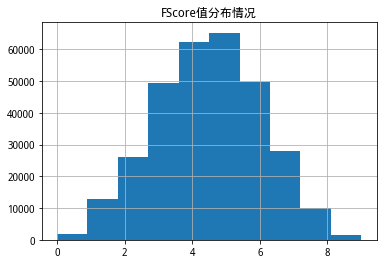

In [157]:
print(f"分布概要\n{FScore_factor.describe().T}")
plt.title('FScore值分布情况')
FScore_factor['FScore'].hist(bins=10)

原始财务指标的统计信息如下，Delta的数据由于是增长率，所以存在较多的极值和缺失，其中 $\Delta LEVELER$ 的缺失非常严重，还需要进一步核查聚宽的因子合成模块

如下图所示，有三项的数据全为空值

In [181]:
basic_df.query("asset=='000001.XSHE'").info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 100 entries, (2014-01-02 00:00:00, 000001.XSHE) to (2022-04-01 00:00:00, 000001.XSHE)
Data columns (total 9 columns):
ROA              100 non-null float64
CFO              99 non-null float64
DELTA_ROA        100 non-null float64
ACCRUAL          99 non-null float64
DELTA_LEVELER    0 non-null float64
DLTA_LIQUID      0 non-null float64
DELTA_MARGIN     0 non-null float64
DELTA_TURN       100 non-null float64
EQ_OFFSER        100 non-null float64
dtypes: float64(9)
memory usage: 43.8+ KB


In [177]:
basic_df.describe().style.format('{:.4f}')

,ROA,CFO,DELTA_ROA,ACCRUAL,DELTA_LEVELER,DLTA_LIQUID,DELTA_MARGIN,DELTA_TURN,EQ_OFFSER
count,307047.0000,306578.0000,290983.0000,306420.0000,272962.0000,285596.0000,286382.0000,286937.0000,291266.0000
mean,1.1084,0.0060,-0.2119,-0.0050,-94.5370,0.0517,0.2003,6291.0571,0.1767
std,1.9969,0.0396,24.4183,0.0395,18924.4855,1.4301,48.2607,3369772.3150,0.6267
min,-124.7700,-1.0898,-3708.0000,-1.2975,-4896347.5711,-67.6335,-1542.3056,-20129.0717,-0.8999
25%,0.2400,-0.0108,-0.5765,-0.0209,-0.4366,-0.1743,-0.1487,-0.1641,0.0000
50%,0.8700,0.0069,-0.1125,-0.0026,0.0194,-0.0283,-0.0125,-0.0106,0.0000
75%,1.8000,0.0243,0.2683,0.0129,0.2605,0.1186,0.1179,0.1642,0.0904
max,114.0100,1.6344,2292.6364,1.6560,2239.4868,264.4299,10209.5201,1805069110.1253,34.8357


通过相关性分析，可以看到，$ACCRUAL$和$CFO$之间具有非常高的相关性

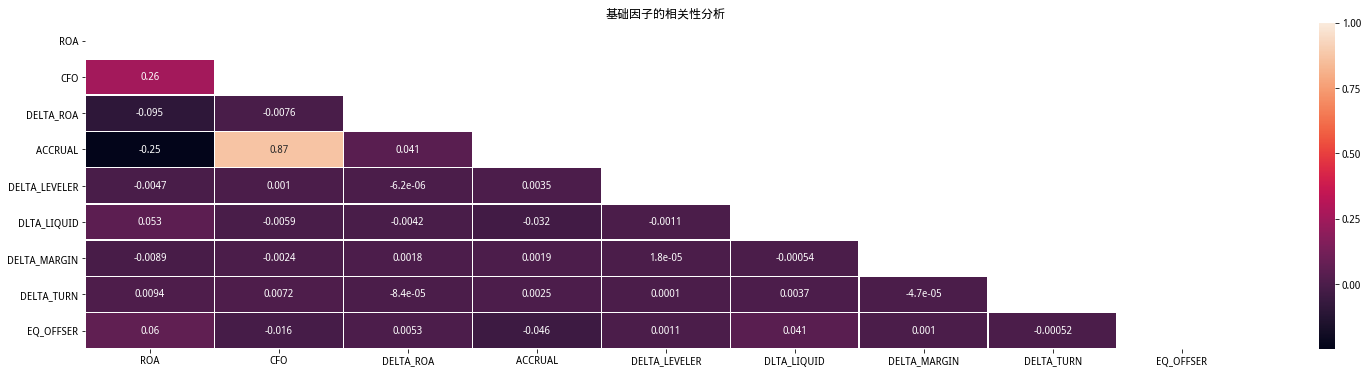

In [183]:
plot_heatmap(df=basic_df, title='基础因子的相关性分析')

## 3.5 因子回测

1. 选股范围为全A,等权重，不考虑交易费用和滑点
2. 样本：2010-01-01至2022-05-01期间的所有A股上市公司。将每期FFScore按【0】、【1-8】、【9】进行分组，按日计算收益率

In [171]:
FScore_factor.tail(3)
# pivot_price.info()#.tail(3)

FScore
date       asset              
2022-04-01 688819.XSHG       6
           688981.XSHG       8
           689009.XSHG       2

In [101]:
factor_data = al.utils.get_clean_factor_and_forward_returns(FScore_factor,
                                                            pivot_price,
                                                            quantiles = None,
                                                            bins=[0,2,7,9],
                                                            periods=(1, 22,),
                                                            max_loss=0.283
                                                           )

Dropped 28.2% entries from factor data (27.8% after in forward returns computation and 0.4% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [102]:
ret = pd.pivot_table(factor_data.reindex(), index='date', columns='factor_quantile', values=1)
ret.rename(columns={1.0: 'FScore低分组',2.0:'FScore中间组', 3.0: 'FScore高分组'}, inplace=True)

In [50]:
# 存储回测结果
pkl_batch(ret, 'ret', 'write')

# 读取回测结果
ret = pkl_batch(file_name='ret', method='read')

ret.tail(3)

factor_quantile,FScore低分组,FScore中间组,FScore高分组
date,,,
2020-04-01,0.041574,0.046555,0.061407
2020-05-06,0.034325,0.033095,0.083571
2020-06-01,0.029797,0.051033,0.112168


注意：由于部分因子的缺失严重，使得近期回测数据无解，2020~2022年大量的数据被过滤掉了

目前没想到什么办法解决这个问题，是后续需要解决的问题

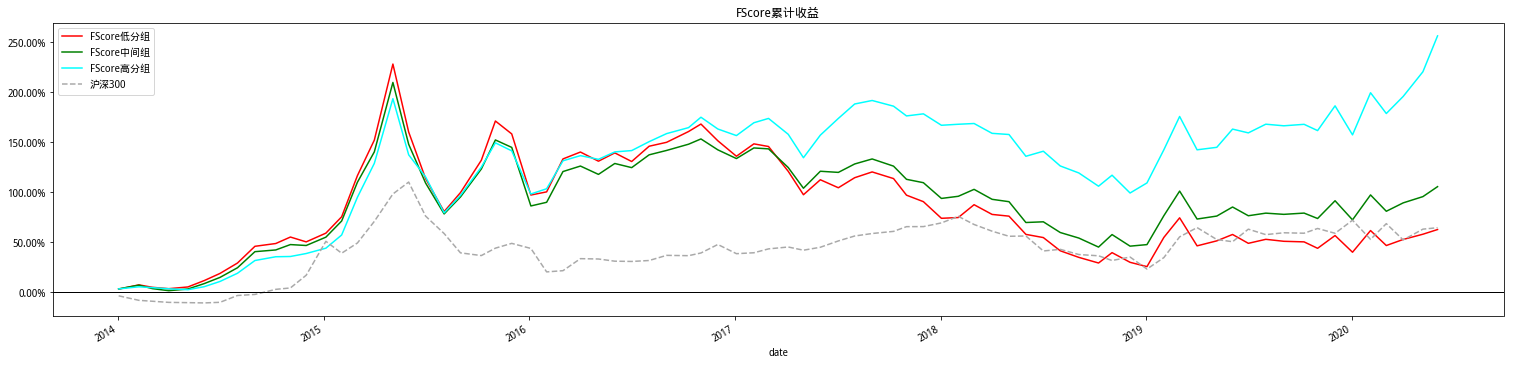

In [103]:
plot_cum_return(title='FScore累计收益', ret=ret, benchmark_ret=benchmark_ret, benchmark_name='沪深300')

仅使用FScore财务模型进行选股,高分组累计收益 256.23%，年化收益 21.59%，夏普及回撤均优于低分组及中间组，总体来说是一个还不错的选股策略。

In [105]:
Strategy_performance(ret,'monthly').style.format('{:.2%}')

factor_quantile,FScore低分组,FScore中间组,FScore高分组
年化收益率,7.74%,11.70%,21.59%
累计收益,62.36%,105.28%,256.23%
波动率,34.05%,31.46%,29.34%
夏普,38.58%,50.75%,81.33%
最大回撤,-61.82%,-53.24%,-38.97%


# 4. PB市净率因子分析

在剔除负市净率的股票后，按照市净率从低到高对 A 股市场中的股票进行分层，按照每层20%均分为5层。其中第1层为市净率前20%的股票，即低市净率股票，第2层为市净率 20%~40%的股票，第3层为市净率 40%~60%的股票，第4层为市净率 60%~80%的股票，第5层为市净率 80%~100%的股票。

按照 PB 的原理，越小越好，所以低分位的因子应该意味着较高收益，即预估第1组收益应该最好。

## 4.1 基础数据获取

In [ ]:
# 获取PB 
pb_list = list(get_factor_pb_ratio(securities, periods))
pb_df = pd.concat(pb_list)

## 4.2 数据存取和读取

In [ ]:
pkl_batch(pb_df, 'pb_df', 'write')
pkl_batch(pivot_pb, 'pivot_pb', 'write')

In [26]:
pb_df = pkl_batch(file_name='pb_df', method='read')
pivot_pb = pkl_batch(file_name='pivot_pb', method='read')

## 4.3 采用 alphalens 库实现的因子分析

In [27]:
# 过滤PB小于0的，即去掉亏损企业
pivot_pb = pd.pivot_table(pb_df, index='day', columns='code', values='pb_ratio')
filter_pb = pivot_pb[pivot_pb > 0]#[50:]
filter_pb.index = pd.to_datetime(filter_pb.index)

# 过滤后的 PB 因子表，组合成 Alphalens 的格式
pb_ser = filter_pb.stack()
pb_ser.index.names = ['date','asset']

In [29]:
# 获取A股中的PB因子，并回测
pb_factor = al.utils.get_clean_factor_and_forward_returns(pb_ser, 
                                                          pivot_price,
                                                          quantiles = 5,
                                                          periods=(1, 22),
                                                          max_loss=0.277
                                                         )

Dropped 27.6% entries from factor data (27.6% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [30]:
pb_factor.tail(3)

1       ...         factor_quantile
date       asset                       ...                        
2020-06-01 688566.XSHG -0.004211       ...                       5
           688588.XSHG -0.107661       ...                       5
           688598.XSHG -0.045789       ...                       5

[3 rows x 4 columns]

In [142]:
pb_ret = pd.pivot_table(pb_factor.reset_index(),index='date', columns='factor_quantile', values=1)

True

In [40]:
# 存储回测结果
pkl_batch(pb_factor, 'pb_factor', 'write')
pkl_batch(pb_ret, 'pb_ret', 'write')

# # 读取回测结果
pb_factor = pkl_batch(file_name='pb_factor', method='read')
pb_ret = pkl_batch(file_name='pb_ret', method='read')

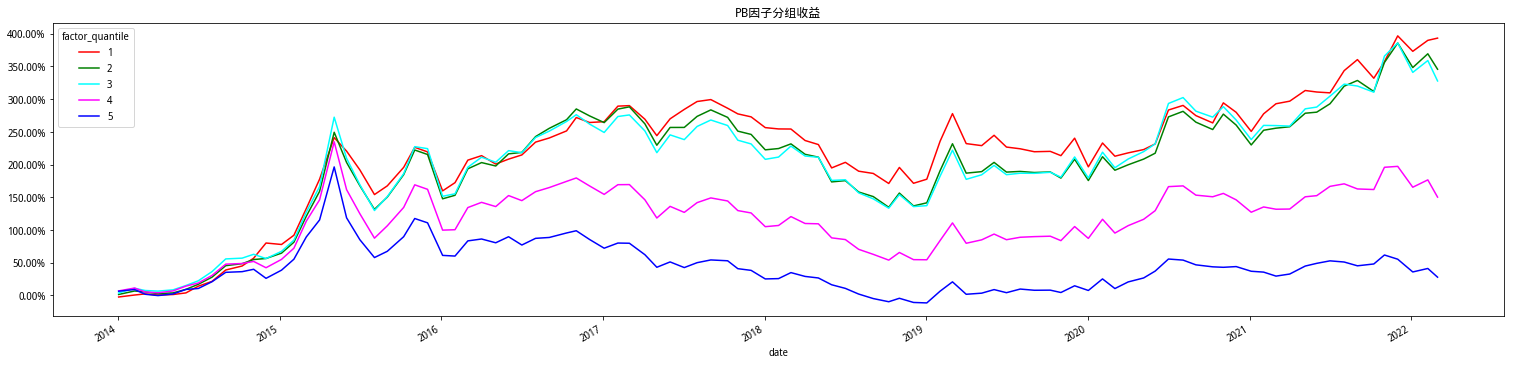

In [76]:
plot_cum_return(title='PB因子分组收益', ret=pb_ret)

PB因子从高到底排列的各个分层,其总收益率分别为21.34%	19.86%	19.27%	11.76%	3.02%。

可以看到PB因子除第2组与第3组之间在分层上有所重叠外，其余分组上分层效果较为明显。由此可以看出PB是一个较好的选股因子。尤其是市净率前20%的股票在各方面指上均明显领先其他各层股票。

所以，综上所述，PB 因子回测与前面的假设一致，也与比乔斯基结论一致，符合低PB股票池优于市场表现的结论。

后续我们将以市净率前20%的股票作为投资组合基准，借鉴比乔斯基方法对 A 股市场进行实证研究。

In [49]:
Strategy_performance(pb_ret,'monthly').style.format('{:.2%}')

factor_quantile,1,2,3,4,5
年化收益率,21.34%,19.86%,19.27%,11.76%,3.02%
累计收益,393.34%,345.78%,327.83%,150.21%,27.77%
波动率,26.04%,29.29%,31.29%,32.05%,32.53%
夏普,87.43%,76.32%,71.59%,50.40%,25.04%
最大回撤,-32.13%,-39.56%,-38.32%,-54.05%,-70.17%


## 4.4 采用聚宽的 jqfactor_analyzer 执行因子分析

In [26]:
# 清除内存，重新执行
pb_df = pkl_batch(file_name='pb_df', method='read')
pivot_pb = pd.pivot_table(pb_df, index='day', columns='code', values='pb_ratio')
filter_pb = pivot_pb[pivot_pb > 0]
filter_pb.index = pd.to_datetime(filter_pb.index)

库文档 [传送门](https://github.com/JoinQuant/jqfactor_analyzer/blob/master/docs/API%E6%96%87%E6%A1%A3.md)

由于平台内存限制，而且analyze_factor()方法采用的内置重算收益率的方法，相当吃内存，所以这里只计算最近2年的因子收益率，作为横向参考比较。本地运行版本不在这里展示。

JQ库理解小结：

- JQ库提供的是傻瓜式计算方式，只需要传入因子值，股价等其他参数不需要传入，由内部封装的 JQdata API 完成计算
- 由于内置了股价计算和行业数据读取，JQ库的使用需要校验聚宽的本地化账号，没有账户不能使用
- JQ 支持第三方因子值，但不支持第三方数据源，需要的话可以魔改
- 500MB 内存大约能支持1年的全市场数据，所以在线版本大约能支持1年半的计算
- JQ 库本身基于 Alphalens 的魔改，修复了 Alphalens 的部分bug，但貌似也很久没有再更新了


从结果上看，依然满足分组的收益预期

/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:159: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"


收益分析


,period_1
Ann. alpha,-0.047
beta,0.853
Mean Period Wise Return Top Quantile (bps),-95.322
Mean Period Wise Return Bottom Quantile (bps),12.027
Mean Period Wise Spread (bps),-107.349


<Figure size 432x288 with 0 Axes>

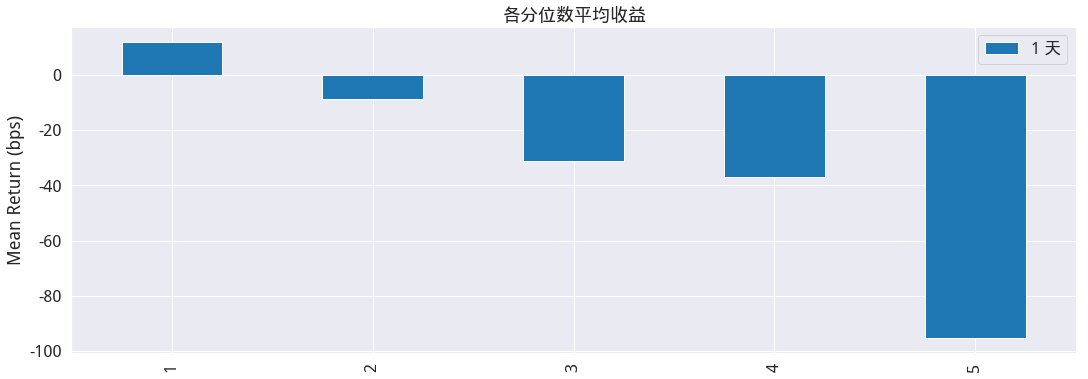

<Figure size 432x288 with 0 Axes>

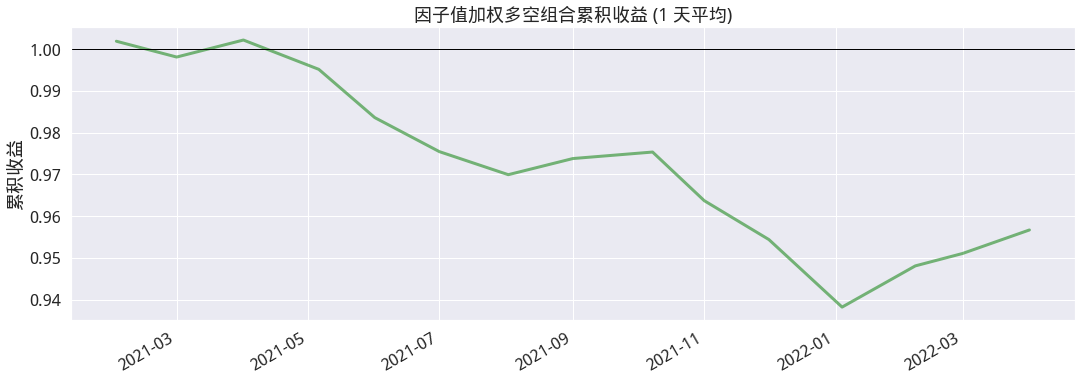

<Figure size 432x288 with 0 Axes>

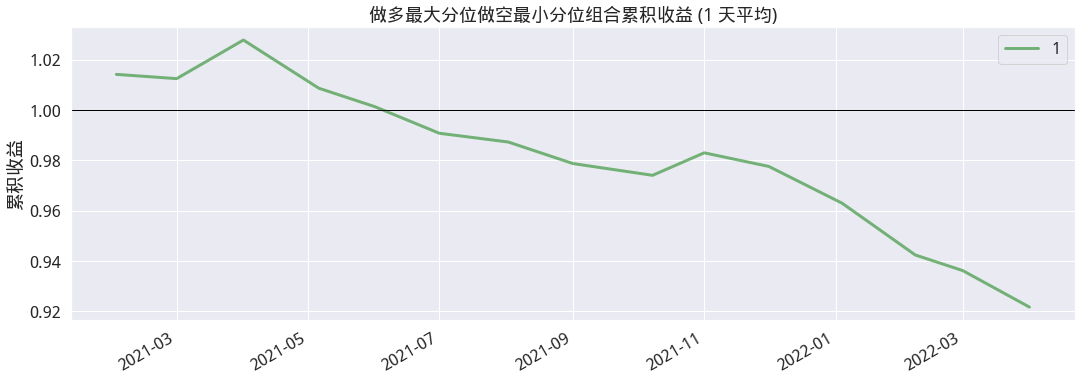

<Figure size 432x288 with 0 Axes>

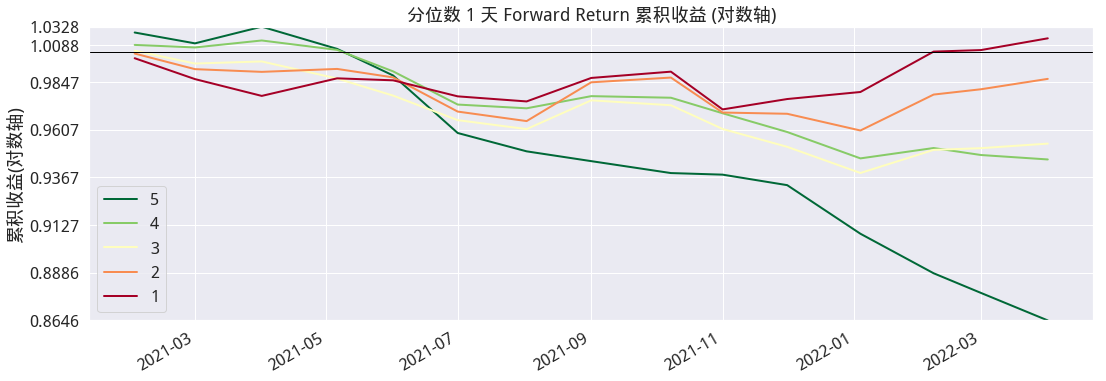

<Figure size 432x288 with 0 Axes>

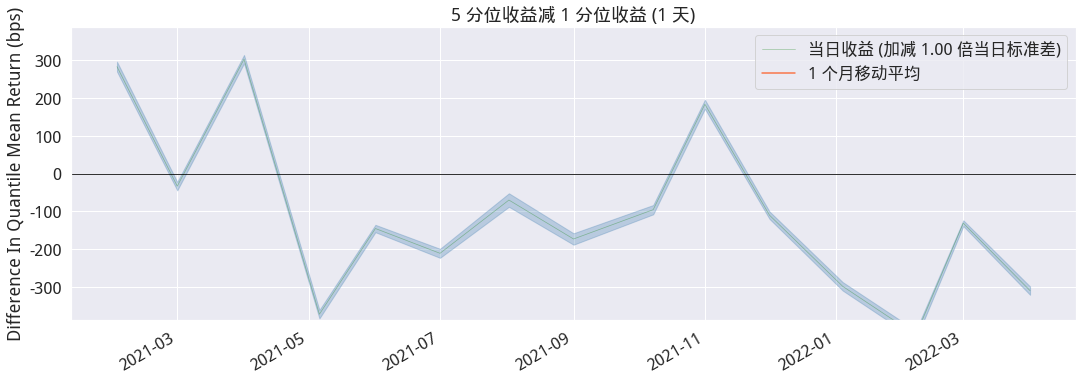

In [15]:
# 
# 在原样本上采用了最近一年的时间区间
filter_pb = filter_pb[80:]
print('计算的时间区间：', filter_pb.index[0].strftime('%Y-%m-%d'), filter_pb.index[-1].strftime('%Y-%m-%d'))

# 运行后的警告不影响结果
far = analyze_factor(factor=filter_pb, start_date=filter_pb.index[0].strftime('%Y-%m-%d'), end_date=filter_pb.index[-1].strftime('%Y-%m-%d'), weight_method='mktcap', industry='sw_l1', quantiles=5, periods=(1,))
far.create_returns_tear_sheet()
# far.create_full_tear_sheet(demeaned=False, group_adjust=False, by_group=False, turnover_periods=None, avgretplot=(5, 15), std_bar=False)

# 5. PB 增强的 Fscore 财务模型因子分析

用 FScore 模型中的 9 个选股标准对低 PB 股票筛选后（即双标准筛选）进行历史回测，同时比较低市净率策略与 FScore 模型高分组之间的差别，看看双标准后是否为改进的方向。

## 5.1 基础数据获得

In [108]:
df = factor_data.copy()
df['pb_group'] = pb_factor['factor_quantile']

# 取 pb为1的低分值组，和Fscore的高分值组，完成筛选
cross_df = df.query('pb_group == 1 and factor_quantile == 3')
cross_ret = pd.pivot_table(cross_df.reset_index(), index='date', columns='factor_quantile',values=1)
cross_ret.tail(3)

factor_quantile,3.0
date,
2020-04-01,0.041592
2020-05-06,0.079302
2020-06-01,0.031685


## 5.2 数据存储和读取

In [143]:
pkl_batch(cross_ret, 'cross_ret', 'write')

True

In [56]:
cross_ret = pkl_batch(file_name='cross_ret', method='read')

## 5.3 因子回测

In [109]:
all_ret = pd.concat((cross_ret[3], ret['FScore高分组'], pb_ret[1], benchmark_ret.reindex(cross_ret.index)), axis=1).dropna()
all_ret.columns = ['改进的FScore累计收益', 'FScore高分组', 'PB因子(低市净率组)', '沪深300']
all_ret.tail(3)

,改进的FScore累计收益,FScore高分组,PB因子(低市净率组),沪深300
date,,,,
2020-04-01,0.041592,0.061407,0.016347,-0.096959
2020-05-06,0.079302,0.083571,0.015926,0.071065
2020-06-01,0.031685,0.112168,0.026791,0.008915


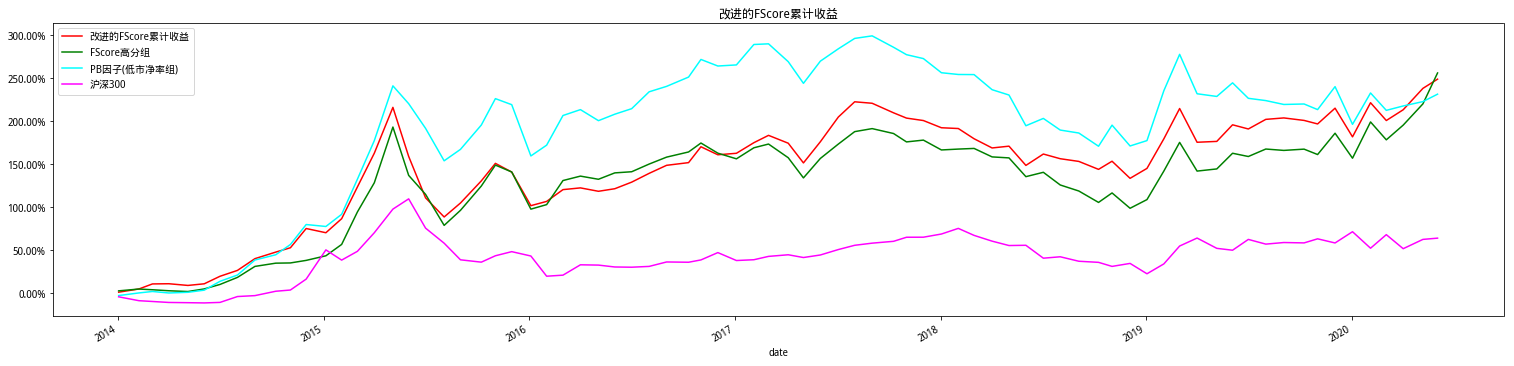

In [110]:
plot_cum_return(title='改进的FScore累计收益', ret=all_ret)

华泰的回测结果
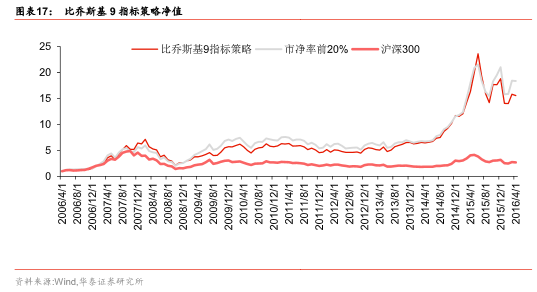

In [125]:
Strategy_performance(all_ret, 'monthly', benchmark='沪深300').style.format('{:.2%}')

,改进的FScore累计收益,FScore高分组,PB因子(低市净率组),沪深300
年化收益率,21.20%,21.59%,20.25%,7.93%
累计收益,249.04%,256.23%,231.58%,64.19%
波动率,26.95%,29.34%,27.50%,25.04%
夏普,85.22%,81.33%,80.78%,42.62%
最大回撤,-40.30%,-38.97%,-32.13%,-42.85%
IR,10.71%,10.98%,10.15%,nan%
Alpha,20.81%,21.44%,19.61%,nan%
超额收益,13.28%,13.66%,12.32%,0.00%


从收益率上看，A股市场中改进的 FScore策略仅跑赢了作为基准的沪深300策略，没有完全跑赢FScore 高分组与市净率低分组。

但同时，改进的 Fscore 产生了最高的回撤，其高波动性对整体收益带来了更多不确定性。

还可以看到，改进的 FScore 收益并不稳定，与FScore 高分组与市净率低分组没有产生较好的单调性，区分度也不高。

因此根据实证可推论，**FScore 模型的增强效果在 A 股市场并没有那么显著**，展开部分参考华泰研报，这里不在赘述。

平均持股数：23.371794871794872


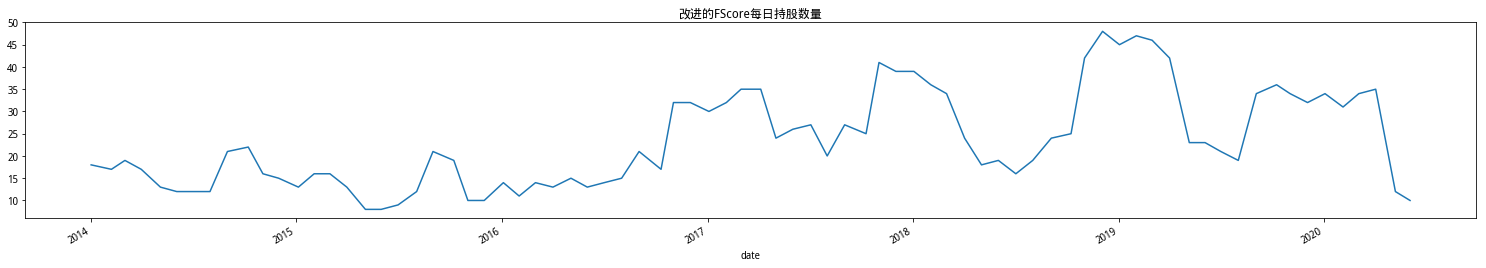

In [118]:
cross_df.groupby(level='date')['factor'].count().plot(title='改进的FScore每日持股数量',figsize=(26,4));
print(f"平均持股数：{cross_df.groupby(level='date')['factor'].count().mean()}")

分析 FScore 模型在A股的适用性，发现A股市场相对于美国市场的波动更高、9个财务指标来进行筛选高分股票数量偏少，全市场选出的平均持股量为23，导致投资收益的风险增大，同时可能还由于财务报告编制方法、中美财务指标的计算原则、以及 A 股市场投资者对财务指标变化的理解有所不同，所以不能获得有效的选股 Alpha。

基于比乔斯基低市净率9指标FScore选股策略的底层逻辑，华泰提出了更适合中国A股市场的 Five FScore（FFScore）低市净率选股模型。

# 6. 华泰改进的 A 股 FFScore财务模型因子分析


## 6.1 基础数据获取

In [137]:
# 获取 FFScore 得分
data_list_ff = list(get_FScore('A', FFScore, periods))

# 因子值 Series
FFScore_factor: pd.Series = pd.concat({pd.to_datetime(f.watch_date): f.ffscore for f in data_list_ff}, names=['date', 'asset'])
FFScore_factor = FFScore_factor.to_frame('FFScore')

# 基础数据
basic_df_ff: pd.DataFrame = pd.concat({f.watch_date: f.basic for f in data_list_ff}, names=['date', 'asset'])
    
FFScore_factor.tail(3)

## 6.2 数据存储和读取

In [139]:
# 储存
pkl_batch(FFScore_factor, 'FFScore', 'write')
pkl_batch(basic_df_ff, 'basic_df_ff', 'write')

True

In [160]:
# 读取
FFScore_factor = pkl_batch(file_name='FFScore', method='read')
basic_df_ff = pkl_batch(file_name='basic_df_ff', method='read')

## 6.3 描述性分析

分布概要
            count      mean       std  min  25%  50%  75%  max
FFScore  307256.0  2.625566  1.386953  0.0  1.0  3.0  4.0  5.0


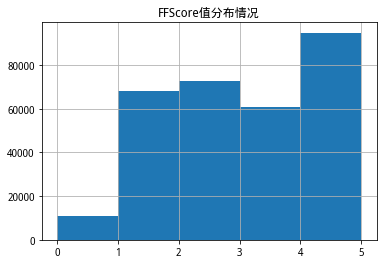

In [161]:
print(f"分布概要\n{FFScore_factor.describe().T}")
plt.title('FFScore值分布情况')
FFScore_factor['FFScore'].hist(bins=5)

## 6.4 因子回测

In [119]:
# 将 FFScore 按 FScore 同样的分组进行回测
factor_data_ff = al.utils.get_clean_factor_and_forward_returns(FFScore_factor,
                                                               pivot_price,
                                                               quantiles = None,
                                                               bins=[0,2,3,5],
                                                               periods=(1,22),
                                                               max_loss=0.302)

Dropped 30.2% entries from factor data (27.8% after in forward returns computation and 2.4% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [120]:
factor_data_ff.tail(3)

1       ...         factor_quantile
date       asset                       ...                        
2020-06-01 688368.XSHG  0.035092       ...                     1.0
           688388.XSHG  0.007516       ...                     1.0
           688389.XSHG  0.080397       ...                     1.0

[3 rows x 4 columns]

In [144]:
ret_ff = pd.pivot_table(factor_data_ff.reindex(), index='date', columns='factor_quantile', values=1)
ret_ff.rename(columns={1.0: 'FFScore低分组', 2.0:'FFScore中间组', 3.0: 'FFScore高分组'}, inplace=True)
ret_ff.tail(3)

factor_quantile,FFScore低分组,FFScore中间组,FFScore高分组
date,,,
2020-04-01,0.038667,0.044412,0.062886
2020-05-06,0.034878,0.024080,0.043293
2020-06-01,0.042554,0.057227,0.081782


In [52]:
# 存储回测结果
pkl_batch(ret_ff, 'ret_ff', 'write')

# 读取回测结果
ret_ff = pkl_batch(file_name='ret_ff', method='read')

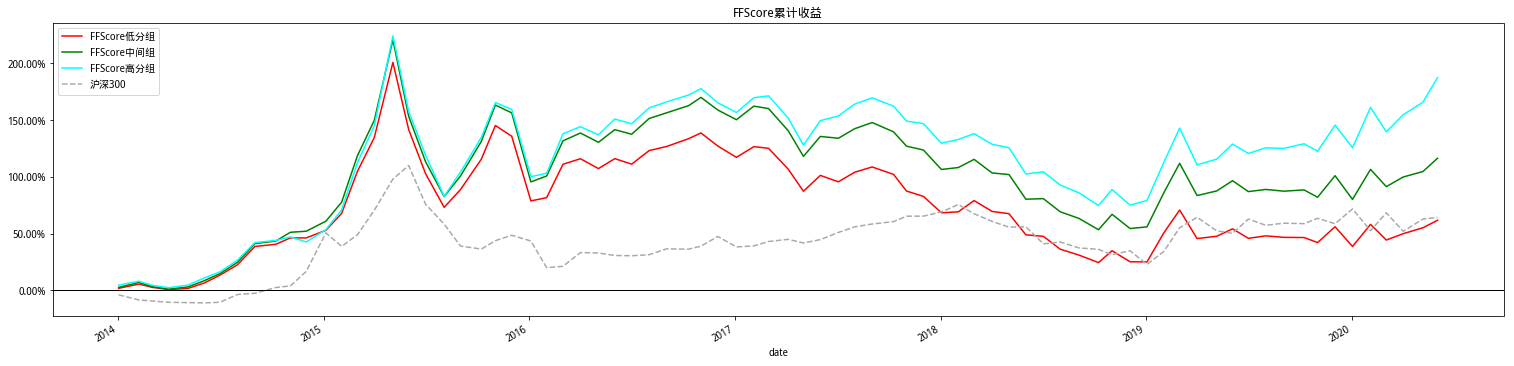

In [127]:
plot_cum_return(title='FFScore累计收益', ret=ret_ff, benchmark_ret=benchmark_ret, benchmark_name='沪深300')

FFScore财务模型选股，高分组（总收益 187.31%）比FScore（总收益 256.23%）有下降，波动率、夏普比和最大回撤基本持平

In [128]:
Strategy_performance(ret_ff, 'monthly').style.format('{:.2%}')

factor_quantile,FFScore低分组,FFScore中间组,FFScore高分组
年化收益率,7.67%,12.60%,17.63%
累计收益,61.66%,116.29%,187.31%
波动率,31.65%,31.51%,32.25%
夏普,38.96%,53.32%,66.34%
最大回撤,-58.63%,-52.17%,-46.11%


# 7. PB增强的 FFScore 财务模型因子分析

同样，这里结合PB对FFScore模型进行增强测试

## 7.1 基础数据获得

In [129]:
df = factor_data_ff.copy()
df['pb_group'] = pb_factor['factor_quantile']

cross_df_ff = df.query('pb_group == 1 and factor_quantile == 3')
cross_ret_ff = pd.pivot_table(cross_df_ff.reset_index(), index='date', columns='factor_quantile', values=1)
cross_ret_ff.tail(3)

factor_quantile,3.0
date,
2020-04-01,0.038250
2020-05-06,0.024742
2020-06-01,0.037039


## 7.2 数据存储和读取

In [145]:
pkl_batch(cross_ret_ff, 'cross_ret_ff', 'write')

True

In [57]:
cross_ret_ff = pkl_batch(file_name='cross_ret_ff', method='read')

## 7.3 因子回测

In [130]:
all_ret = pd.concat((cross_ret_ff[3], ret_ff['FFScore高分组'], pb_ret[1], benchmark_ret.reindex(cross_ret_ff.index)), axis=1).dropna()
all_ret.columns = ['改进的FFScore累计收益', 'FFScore高分组', 'PB因子(低市净率组)','沪深300']

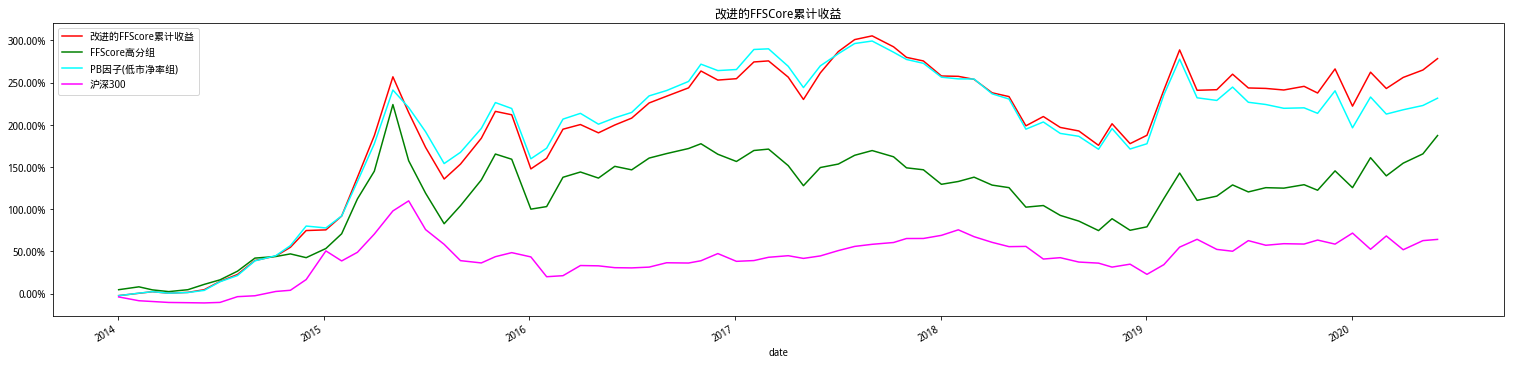

In [131]:
plot_cum_return(title='改进的FFSCore累计收益', ret=all_ret)

华泰的回测结果

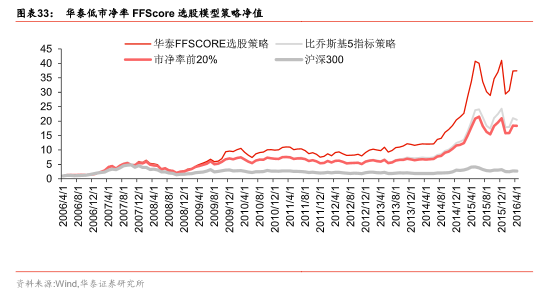

In [132]:
Strategy_performance(all_ret,'monthly', benchmark='沪深300').style.format('{:.2%}')

,改进的FFScore累计收益,FFScore高分组,PB因子(低市净率组),沪深300
年化收益率,22.73%,17.63%,20.25%,7.93%
累计收益,278.52%,187.31%,231.58%,64.19%
波动率,28.92%,32.25%,27.50%,25.04%
夏普,85.38%,66.34%,80.78%,42.62%
最大回撤,-33.95%,-46.11%,-32.13%,-42.85%
IR,12.01%,8.47%,10.15%,nan%
Alpha,21.90%,18.58%,19.61%,nan%
超额收益,14.80%,9.70%,12.32%,0.00%


相较于FFScore选股策略，结合低市盈率后收益从17.99%提升至22.73%，接近了原 FScore 和改进的 FScore版本。

同时，收益和PB过于趋同，不排除选股的结果最终和PB接近。

相比较华泰研究，这里将回测从2016年向后推进了4年，但并没有取得原设计中的期望效果，说明可能因子目前已经失效。

平均持股数：162.0


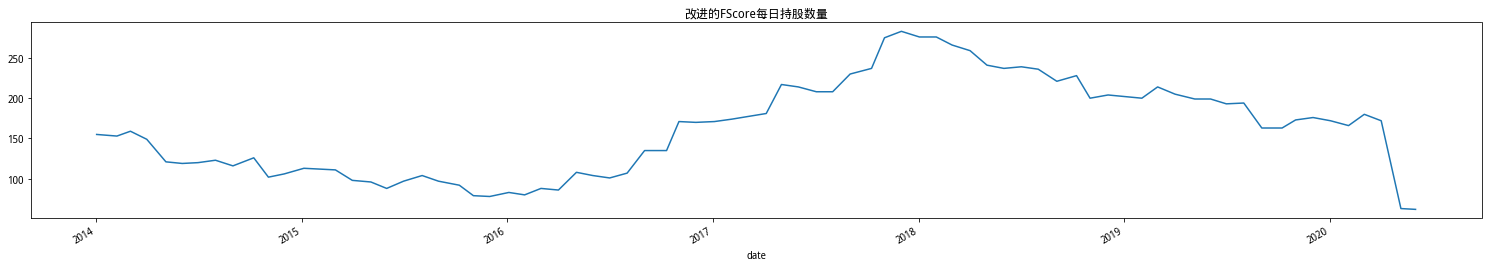

In [134]:
cross_df_ff.groupby(level='date')['factor'].count().plot(title='改进的FScore每日持股数量',figsize=(26,4))
print(f"平均持股数：{cross_df_ff.groupby(level='date')['factor'].count().mean()}")

改进的持仓量明显上升，持股量高于原策略，换手率也相应的增加了。

## 7.4 因子的行业分布统计

接下来，看看策略在行业上的选择偏好：

In [135]:
cross_df_ff['industry'] = cross_df_ff.groupby(level='date').apply(lambda x: get_stock_ind(x.index.get_level_values(1).values.tolist(), x.name, 'sw_l1', 'industry_name'))

In [139]:
cross_df_ff.tail()

1        22    ...     pb_group  industry
date       asset                              ...                       
2020-06-01 601567.XSHG -0.006139  0.612102    ...          1.0     电气设备I
           601616.XSHG -0.023952  0.050898    ...          1.0     电气设备I
           601618.XSHG  0.006944  0.541667    ...          1.0     建筑装饰I
           601880.XSHG  0.004505  0.069820    ...          1.0     交通运输I
           601908.XSHG  0.027674  0.669505    ...          1.0     电气设备I

[5 rows x 6 columns]

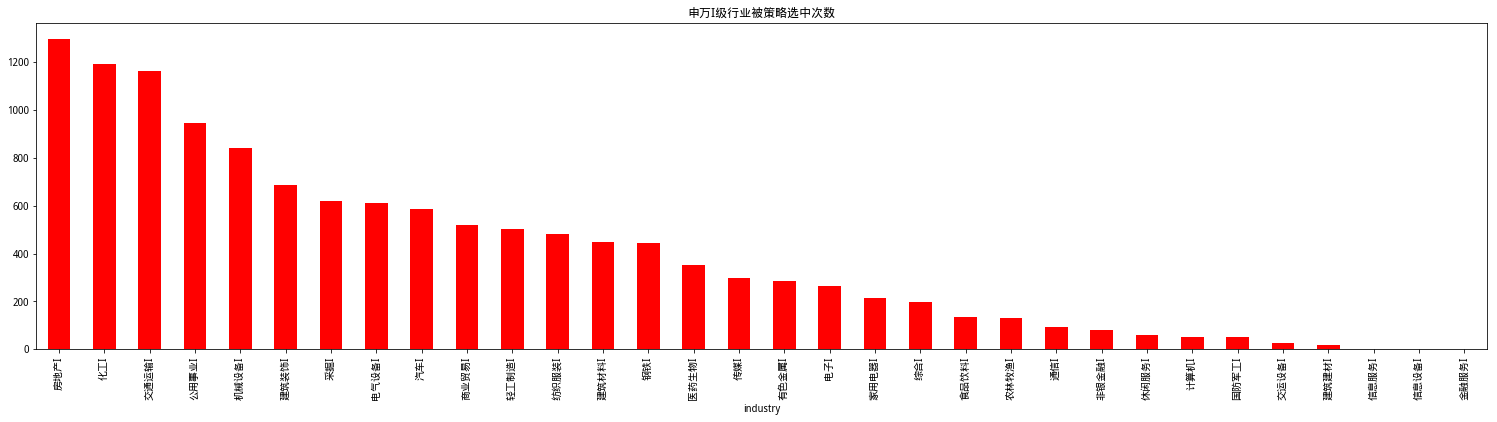

In [136]:
cross_df_ff.groupby('industry')[1].count().sort_values(ascending=False).plot.bar(color='r', figsize=(26, 6), title='申万I级行业被策略选中次数');

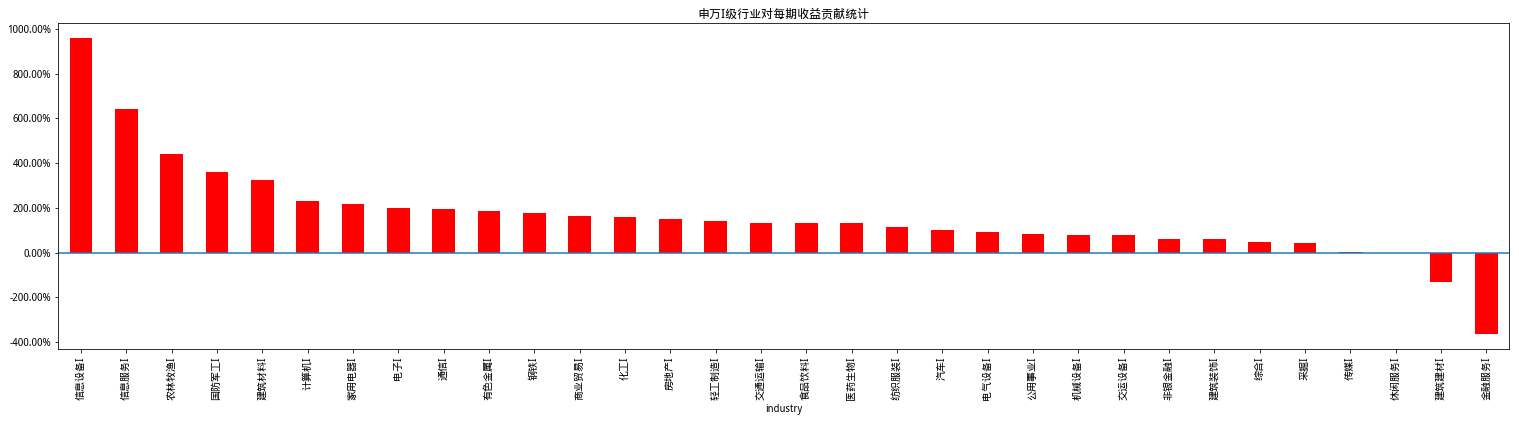

In [138]:
fig,ax = plt.subplots(figsize=(26, 6))

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos:'{:.2%}'.format(x * 100)))
cross_df_ff.groupby('industry')[1].mean().sort_values(ascending=False).plot.bar(color='r', title='申万I级行业对每期收益贡献统计', ax=ax)
plt.axhline(0)

# 8. 因子归因分析

使用随机森林算法分析因子的选股特征，考察各财务指标对因子合成的真实贡献

## 8.1 基础数据获取

In [84]:
all_fundamentals_list = list(get_FScore('A', F13_Score, periods))

all_fundamentals: pd.Series = pd.concat({pd.to_datetime(f.watch_date): f.basic for f in all_fundamentals_list}, names=['date', 'asset'])
# all_fundamentals = all_fundamentals.to_frame('F13_Score')

## 8.2 数据存储和读取

In [85]:
pkl_batch(all_fundamentals, 'all_fundamentals', 'write')

True

In [6]:
all_fundamentals = pkl_batch(file_name='all_fundamentals', method='read')

## 8.3 描述性分析

仅杠杆比率($\Delta LEVER$)的缺失率高于10%

In [153]:
all_fundamentals.isna().sum() / len(all_fundamentals)

ROE             0.000683
DELTA_ROE       0.051726
ROA1            0.000680
DELTA_ROA1      0.052962
ROA2            0.022519
DELTA_ROA2      0.084666
ACCRUAL         0.002721
DELTA_LEVER     0.111614
DLTA_LIQUID     0.070495
DELTA_MARGIN    0.067937
EQ_OFFSER       0.052041
DELTA_CATURN    0.084682
DELTA_TURN      0.066131
PB_RATIO        0.000000
dtype: float64

In [7]:
all_fundamentals.describe()

,ROE,DELTA_ROE,ROA1,DELTA_ROA1,ROA2,DELTA_ROA2,ACCRUAL,DELTA_LEVER,DLTA_LIQUID,DELTA_MARGIN,EQ_OFFSER,DELTA_CATURN,DELTA_TURN,PB_RATIO
count,307046.000000,291363.000000,307047.000000,290983.000000,300337.000000,281242.000000,306420.000000,2.729620e+05,285596.000000,286382.000000,291266.000000,2.812370e+05,2.869370e+05,307256.000000
mean,1.610106,-0.182323,1.108394,-0.211880,0.016142,-0.680024,-0.005043,-9.453703e+01,0.051676,0.200292,0.176748,1.014950e+04,6.291057e+03,5.661878
std,166.235309,31.294539,1.996888,24.418291,0.029245,113.889602,0.039540,1.892449e+04,1.430089,48.260712,0.626730,5.382256e+06,3.369772e+06,105.674809
min,-90072.507800,-2973.666667,-124.770000,-3708.000000,-0.905037,-16572.937161,-1.297513,-4.896348e+06,-67.633544,-1542.305556,-0.899908,-2.031474e+04,-2.012907e+04,-3849.989300
25%,0.506400,-0.574468,0.240000,-0.576500,0.004448,-0.505252,-0.020874,-4.365766e-01,-0.174282,-0.148676,0.000000,-1.663048e-01,-1.641327e-01,1.821975
50%,1.660000,-0.099099,0.870000,-0.112549,0.011399,-0.087769,-0.002591,1.936711e-02,-0.028345,-0.012456,0.000000,5.000604e-03,-1.059038e-02,2.898300
75%,3.080000,0.287895,1.800000,0.268296,0.022230,0.313864,0.012893,2.605456e-01,0.118600,0.117906,0.090393,2.106955e-01,1.642437e-01,4.747500
max,4911.350100,6181.052697,114.010000,2292.636364,1.665542,9524.576200,1.655954,2.239487e+03,264.429942,10209.520133,34.835679,2.854306e+09,1.805069e+09,18637.306600


## 8.4 随机森林回归分析

华泰对 FFScore 的构建采用了对13指标进行相关性分析，结合业务逻辑设计而成。

那这里采用随机森林的办法，延长样本空间，以同样的相关性分析方式，看看是否可以构造出一个最新版本的 FScore。

这里选择随机森林模型的好处是，其具有较强的解释性，能处理高维度数据，并且不做特征选择，训练完成后，可以给出权重重要性，速度各方面也比较快，算法具备先天的归因优势。

In [156]:
len(price_periods)

148

In [11]:
# 样本间隔
test_period = 120

# 训练集
X_train_time = price_periods[:test_period]

X_train = all_fundamentals.loc[X_train_time]
X_train = X_train.iloc[:, :-1]  # 不计入 PB
y_train = next_ret.loc[X_train_time]
y_train = y_train.reindex(X_train.index)

# 测试集
X_test = all_fundamentals.loc[price_periods[test_period:]]
X_test_fundamentals = X_test.iloc[:,:-1]
X_test_pb = X_test.iloc[:,-1]
y_test = next_ret.reindex(X_test.index)

In [ ]:
# 机器学习
rnd_clf = RandomForestClassifier(n_estimators=200,  # 树木数量，即基评估器的数量。越大模型效果越好，也容易过拟合
                                 min_samples_leaf=1000,  # 叶子节点必须具有的最小样本数
                                 min_samples_split=30,  # 节点在分割前必须具有的最小样本数
                                 max_leaf_nodes=8,  # 最大叶节点数量
                                 max_depth=10,  # 树的最大深度
                                 n_jobs=-1,  # 并行job个数，-1时启用全部CPU
                                 random_state=50,  # 控制bootstrap的随机性，控制生成多少颗树
                                 criterion='entropy'  # 分裂节点的标准，默认 gini，这里采取熵模式
                                )
# 拟合
rnd_clf.fit(X_train.fillna(0).values, sign(y_train).values)

In [4]:
# 存储结果
pkl_batch(rnd_clf, 'rnd_clf', 'write')

# 读取结果
rnd_clf = pkl_batch(file_name='rnd_clf', method='read')

将决策树可视化，用于查看优化的可能方向，以及因子的解释路径。

能明显看到，最重要的根节点是 $\Delta TURN$，决定了总的分类方向，意味着在A股市场，资产周转率对股票收益的影响是非常重要的。

子节点的熵提纯效果和样本数差距不算太大，还能在可理解的范围内。

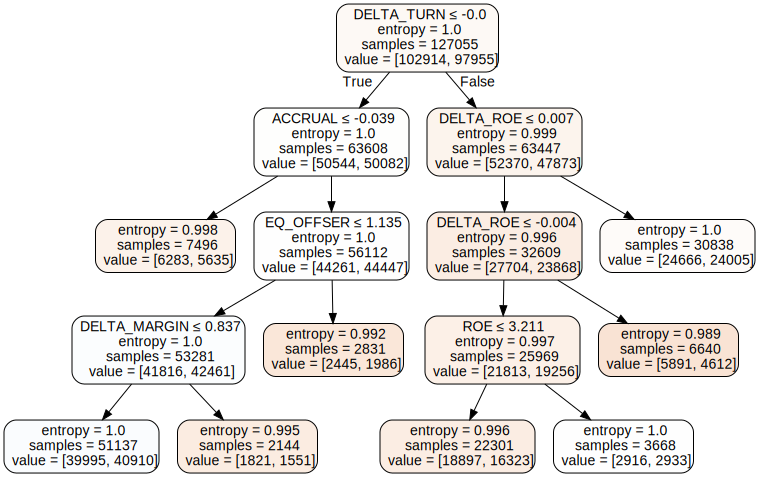

In [19]:
dot_data = export_graphviz(rnd_clf.estimators_[-1],  # 使用最近的决策树
                           out_file=None,
                           feature_names=X_train.columns.tolist(),
                           filled=True,
                           rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

## 8.5 因子的特征分析

绘制出各特征因子的权重分布，以总80%的贡献值为界，可以看到 $\Delta Turn, ROE, \Delta Margin, \Delta ROE, ROA1, \Delta ROA1, \Delta CATURN, ACCRUAL$ 合计解释了80%的收益归因。

那么这里采取对这8个因子做进一步分析合成

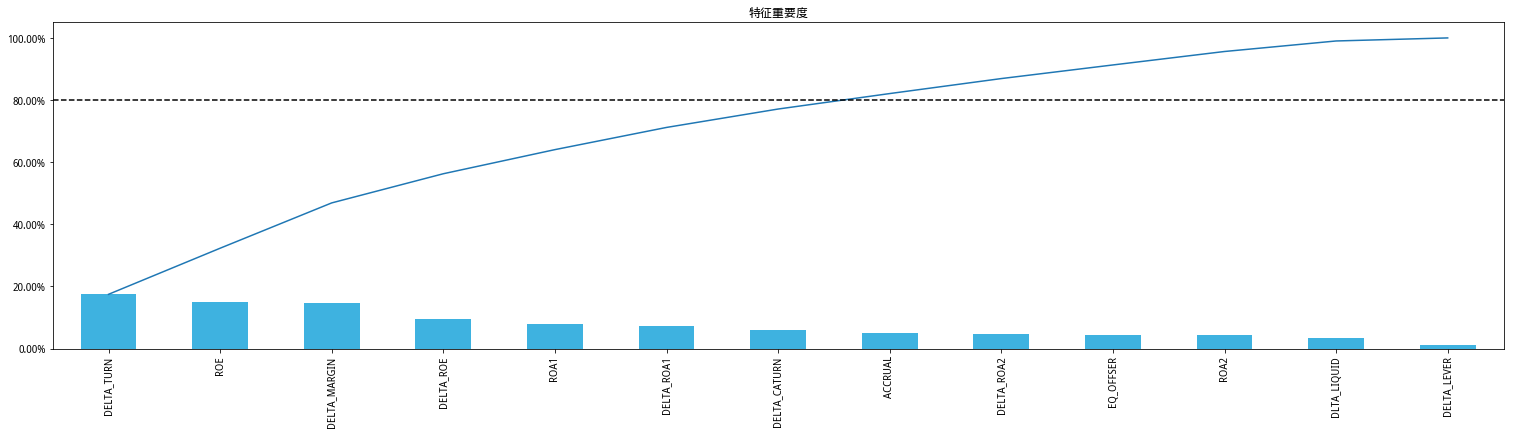

In [20]:
# 特征重要性
feature_score = pd.Series(index=X_train.columns.tolist(), data=rnd_clf.feature_importances_).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(26, 6))
ax.set_title('特征重要度')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.2%}'.format(x)))
feature_score.plot.bar(ax=ax,color='#3EB2E0')
feature_score.cumsum().plot.line(ax=ax, rot=90)
plt.axhline(0.8,color='black',ls='--');

In [185]:
# 因子每期截面均值
corr = X_train.groupby(level='date').corr()
for i, (trade, df) in enumerate(corr.groupby(level='date'), start=1):
    if i == 1:
        corr_mean = df.xs(trade)
    else:
        corr_mean += df.xs(trade)
corr_mean /= i

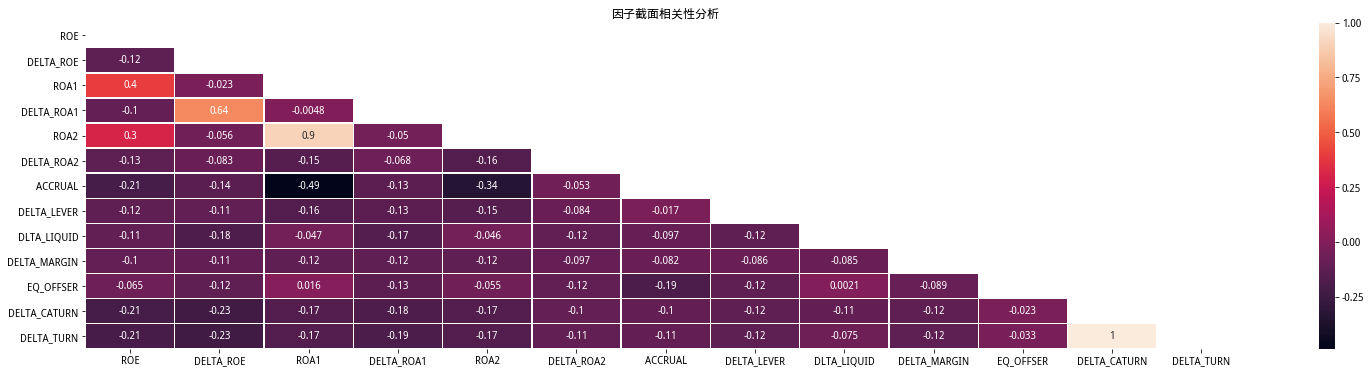

In [186]:
plot_heatmap(df=corr_mean, title='因子截面相关性分析')

通过因子的界面相关性热力图，可以看到$\Delta ROA1$与$\Delta ROE$相关系数为0.64，$ROA2$与$ROE1$相关系数为0.9，为了降低共线性，这里做一个剔除的决定

在  $\Delta Turn, ROE, \Delta Margin, \Delta ROE, ROA1, \Delta ROA1, \Delta CATURN, ACCRUAL$ 的基础上，剔除 $\Delta ROA1$，又$ROA2$不在其中，忽略掉。

最终，构建以 $\Delta Turn, ROE, \Delta Margin, \Delta ROE, ROA1, \Delta CATURN, ACCRUAL$ 为基础的7因子财务打分模型，即 Seven FScore

- **盈利水平**

    - $ROE$
    - $\Delta ROE$
    - $ROA1$
    - $ACCRUAL$

- **财务杠杆及流动性**

    - $\Delta CATURN$

- **运营效率**

    - $\Delta MAGRIN$
    - $\Delta TURN$

$SFScore = \Delta Turn + ROE + \Delta Margin + \Delta ROE + ROA1 + \Delta CATURN + ACCRUAL$

# 9. 基于 ML 分析得的新因子 Seven FScore

## 9.1 基础数据获取

In [59]:
sfscore = sign(all_fundamentals[['DELTA_TURN', 'ROE', 'DELTA_MARGIN', 'DELTA_ROE', 'ROA1', 'DELTA_CATURN', 'ACCRUAL']]).sum(axis=1)

# sfscore.name = 'SFScore'
sfscore = sfscore.to_frame('SFScore')

In [60]:
sfscore.tail(3)

SFScore
date       asset               
2022-04-01 688819.XSHG        3
           688981.XSHG        7
           689009.XSHG        2

## 9.2 数据存储和读取

In [61]:
# 储存
pkl_batch(sfscore, 'sfscore', 'write')

True

In [188]:
# 读取
sfscore = pkl_batch(file_name='sfscore', method='read')

## 9.3 描述性分析

分布概要
            count      mean       std  min  25%  50%  75%  max
SFScore  307256.0  3.897594  1.616666  0.0  3.0  4.0  5.0  7.0


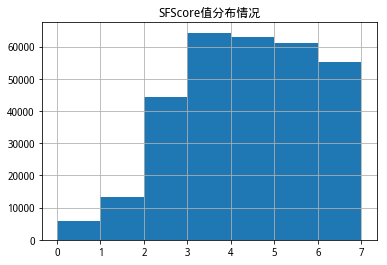

In [189]:
print(f"分布概要\n{sfscore.describe().T}")
plt.title('SFScore值分布情况')
sfscore['SFScore'].hist(bins=7)

## 9.4 因子回测

In [63]:
factor_data_sfs = al.utils.get_clean_factor_and_forward_returns(sfscore,
                                                               pivot_price,
                                                               quantiles = None,
                                                               bins=[0,2,5,7],
                                                               periods=(1, 22,),
                                                               max_loss=0.28
                                                               )

Dropped 29.1% entries from factor data (27.8% after in forward returns computation and 1.3% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [64]:
ret_sfs = pd.pivot_table(factor_data_sfs.reindex(), index='date', columns='factor_quantile', values=1)
ret_sfs.rename(columns={1.0: 'SFScore低分组', 2.0:'SFScore中间组', 3.0: 'SFScore高分组'}, inplace=True)
ret_sfs.tail(3)

factor_quantile,SFScore低分组,SFScore中间组,SFScore高分组
date,,,
2020-04-01,0.027912,0.044664,0.068244
2020-05-06,0.030261,0.036310,0.043837
2020-06-01,0.026061,0.055682,0.105587


In [65]:
# 存储回测结果
pkl_batch(ret_sfs, 'ret_sfs', 'write')

# 读取回测结果
ret_sfs = pkl_batch(file_name='ret_sfs', method='read')

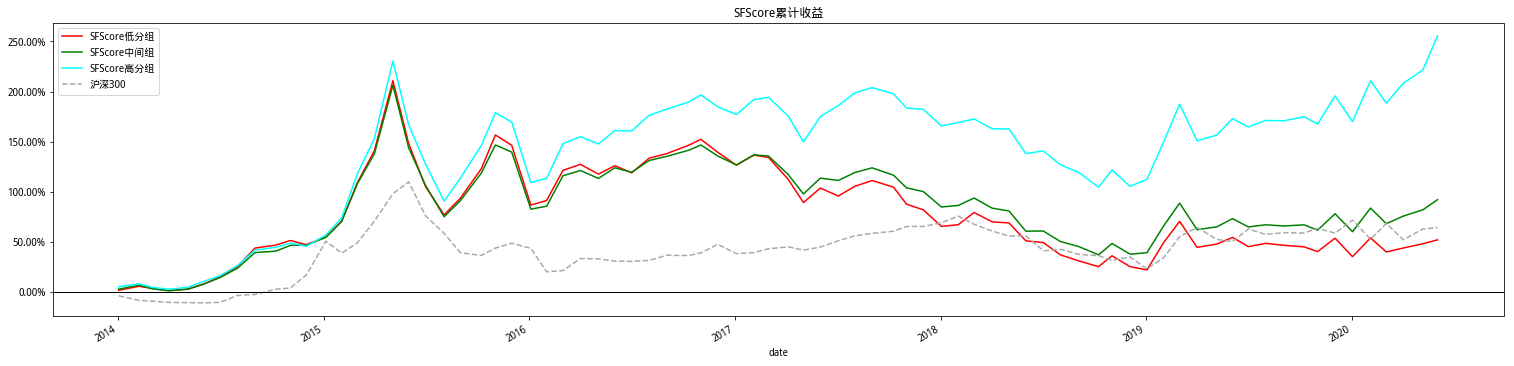

In [66]:
plot_cum_return(title='SFScore累计收益', ret=ret_sfs, benchmark_ret=benchmark_ret, benchmark_name='沪深300')

回测看到，因子呈现了较好的单调性，高分组的收益比华泰的 FFScore 还搞，同时回撤相对较低

但是，这里的回测与归因分析的数据集重合，所以存在较高的过拟合性，也进一步说明归因分析中，较好的找到了各基本面信息对股票收益的解释性

In [67]:
Strategy_performance(ret_sfs,'monthly').style.format('{:.2%}')

factor_quantile,SFScore低分组,SFScore中间组,SFScore高分组
年化收益率,6.64%,10.56%,21.55%
累计收益,51.88%,92.02%,255.60%
波动率,33.13%,31.35%,31.72%
夏普,35.68%,47.54%,77.41%
最大回撤,-60.80%,-55.31%,-42.31%


## 9.5 样本外回测

In [78]:
sfscore_test = sign(X_test_fundamentals[['DELTA_TURN', 'ROE', 'DELTA_MARGIN', 'DELTA_ROE', 'ROA1', 'DELTA_CATURN', 'ACCRUAL']]).sum(axis=1)

In [79]:
factor_data_sfs_test = al.utils.get_clean_factor_and_forward_returns(sfscore_test,
                                                                   pivot_price,
                                                                   quantiles = None,
                                                                   bins=[0,2,5,7],
                                                                   periods=(1, 22,),
                                                                   max_loss=0.81
                                                                   )

Dropped 80.9% entries from factor data (80.2% after in forward returns computation and 0.7% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


80% 的数据抛弃，这里原因主要是原因子合成中存在大量缺失，所以回测效果有一定争议

In [80]:
ret_sfs_test = pd.pivot_table(factor_data_sfs_test.reindex(), index='date', columns='factor_quantile', values=1)
ret_sfs_test.rename(columns={1.0: 'SFScore低分组', 2.0:'SFScore中间组', 3.0: 'SFScore高分组'}, inplace=True)
ret_sfs_test.tail(3)

factor_quantile,SFScore低分组,SFScore中间组,SFScore高分组
date,,,
2020-04-01,0.027912,0.044664,0.068244
2020-05-06,0.030261,0.036310,0.043837
2020-06-01,0.026061,0.055682,0.105587


In [118]:
# 获取样本外的基准收益率
benchmark_test = list(get_factor_price('000300.XSHG', get_trade_period(price_periods[test_period-1], price_periods[-1], 'M')))
benchmark_test = pd.concat(benchmark_test)
benchmark_test_ret = benchmark_test['close'].pct_change()

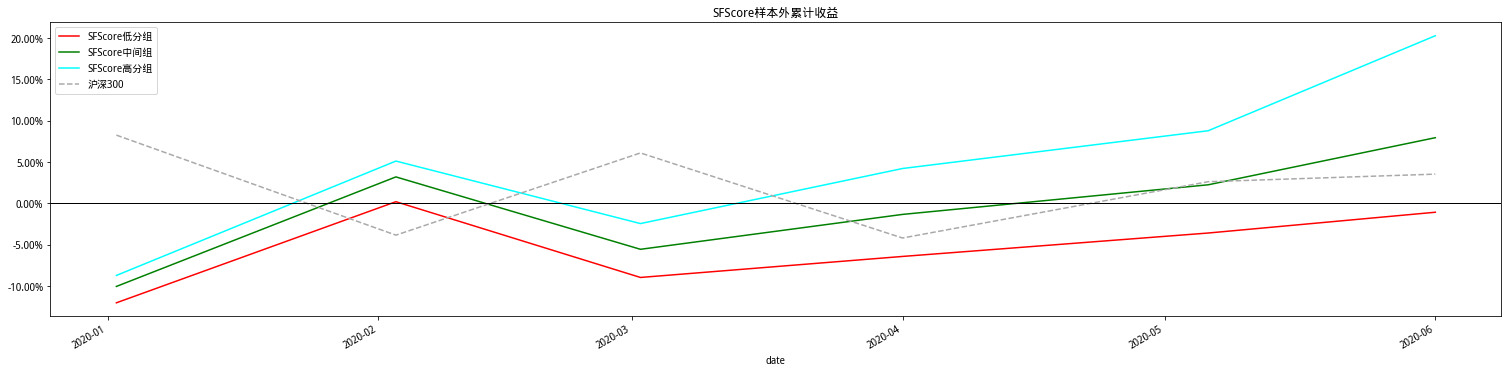

In [121]:
plot_cum_return(title='SFScore样本外累计收益', ret=ret_sfs_test, benchmark_ret=benchmark_test_ret, benchmark_name='沪深300')

样本外的表现还是不错的，不仅体现了良好的区分度，还跑赢了基准沪深300

In [122]:
Strategy_performance(ret_sfs_test,'monthly').style.format('{:.2%}')

factor_quantile,SFScore低分组,SFScore中间组,SFScore高分组
年化收益率,-2.15%,16.49%,44.62%
累计收益,-1.08%,7.93%,20.26%
波动率,32.68%,32.41%,33.26%
夏普,7.02%,60.81%,126.29%
最大回撤,-12.03%,-10.05%,-8.72%


# 10. PB增强的 SFScore 财务模型因子分析

同样，这里结合PB对FFScore模型进行增强测试

## 10.1 基础数据获得

In [68]:
df = factor_data_sfs.copy()
df['pb_group'] = pb_factor['factor_quantile']

cross_df_sfs = df.query('pb_group == 1 and factor_quantile == 3')
cross_ret_sfs = pd.pivot_table(cross_df_sfs.reset_index(), index='date', columns='factor_quantile', values=1)
cross_ret_sfs.tail(3)

factor_quantile,3.0
date,
2020-04-01,0.045504
2020-05-06,0.021531
2020-06-01,0.047434


## 10.2 数据存储和读取

In [69]:
pkl_batch(cross_ret_sfs, 'cross_ret_sfs', 'write')

True

In [ ]:
cross_ret_sfs = pkl_batch(file_name='cross_ret_sfs', method='read')

## 10.3 因子回测

In [70]:
all_ret = pd.concat((cross_ret_sfs[3], ret_sfs['SFScore高分组'], pb_ret[1], benchmark_ret.reindex(cross_ret_sfs.index)), axis=1).dropna()
all_ret.columns = ['改进的SFScore累计收益', 'SFScore高分组', 'PB因子(低市净率组)', '沪深300']
all_ret.tail(3)

,改进的SFScore累计收益,SFScore高分组,PB因子(低市净率组),沪深300
date,,,,
2020-04-01,0.045504,0.068244,0.016347,-0.096959
2020-05-06,0.021531,0.043837,0.015926,0.071065
2020-06-01,0.047434,0.105587,0.026791,0.008915


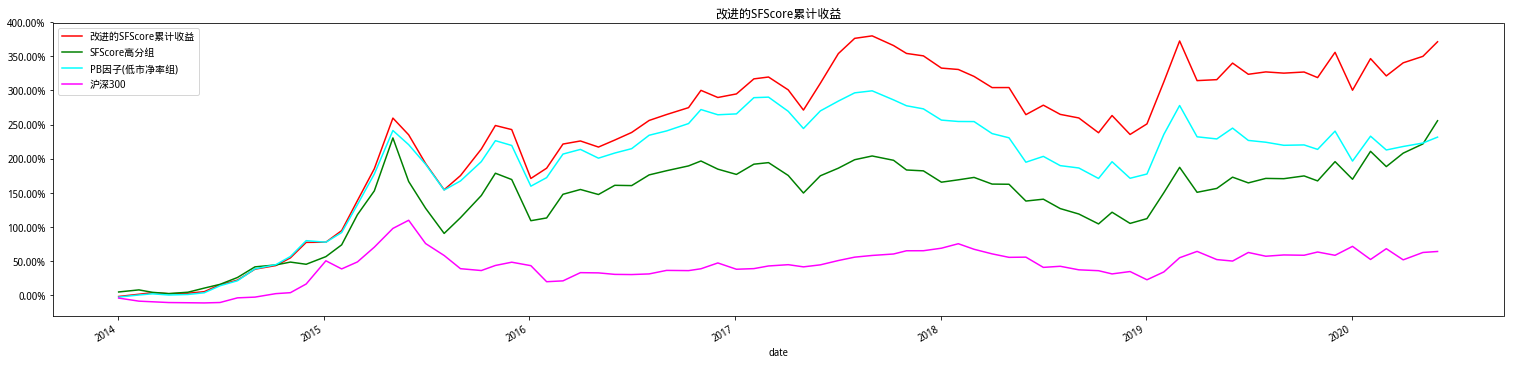

In [71]:
plot_cum_return(title='改进的SFScore累计收益', ret=all_ret)

明显看到，改进后的版本效果非常显著

当然，这里不排除过拟合的可能性，因为区间包含了样本内和样本外

In [72]:
Strategy_performance(all_ret, 'monthly', benchmark='沪深300').style.format('{:.2%}')

,改进的SFScore累计收益,SFScore高分组,PB因子(低市净率组),沪深300
年化收益率,26.93%,21.55%,20.25%,7.93%
累计收益,371.17%,255.60%,231.58%,64.19%
波动率,28.53%,31.72%,27.50%,25.04%
夏普,98.17%,77.41%,80.78%,42.62%
最大回撤,-30.08%,-42.31%,-32.13%,-42.85%
IR,14.97%,11.11%,10.15%,nan%
Alpha,25.26%,21.73%,19.61%,nan%
超额收益,19.00%,13.63%,12.32%,0.00%


# 11. 多模型的横向比较

可以看到，从原始模型至改进模型，单独使用模型进行选股的选股能力是不稳定，且华泰的改进版本还是减弱的，由原始的21.59% 减弱至 17.63%，本文提出的改进版有所改善

In [73]:
score_ret_df = pd.concat((ret['FScore高分组'], ret_ff['FFScore高分组'], ret_sfs['SFScore高分组']),axis=1)

Strategy_performance(score_ret_df, 'monthly').style.format('{:.2%}')

,FScore高分组,FFScore高分组,SFScore高分组
年化收益率,21.59%,17.63%,21.55%
累计收益,256.23%,187.31%,255.60%
波动率,29.34%,32.25%,31.72%
夏普,81.33%,66.34%,77.41%
最大回撤,-38.97%,-46.11%,-42.31%


结合 PB 的增强，选股的收益是依次增加的，本文提出的改进版效果最优，并且均优于原始模型

In [74]:
cross_ret_df = pd.concat((cross_ret[3], cross_ret_ff[3], cross_ret_sfs[3]), axis=1)
cross_ret_df.columns = ['FScore累计收益', '华泰改进的FFScore累计收益', '本文改进的SFScore累计收益']

Strategy_performance(cross_ret_df, 'monthly').style.format('{:.2%}')

,FScore累计收益,华泰改进的FFScore累计收益,本文改进的SFScore累计收益
年化收益率,21.20%,22.73%,26.93%
累计收益,249.04%,278.52%,371.17%
波动率,26.95%,28.92%,28.53%
夏普,85.22%,85.38%,98.17%
最大回撤,-40.30%,-33.95%,-30.08%


# 12. 小总结

- **因子分析的流程总结**
    
    本文完整地梳理了聚宽平台上，对于一个因子的构造、回测、检验的完整流程，其中代码封装了部分常用的函数，可以在后续因子挖掘中继续使用
    
    本文在因子收益归因的过程中，一定程度上整理了一个因子构造的流程，通过随机森林这样具有解释效应的算法，找到了对收益解释性较高的基本面因子组合。本文对该组合因子的使用采用了等权，可预见的是，其性能还有非常大的改善空间，例如可以通过多层分组回归的方式做进一步合成，或者可以通过机器学习的算法，去寻找因子间的非线性关系组合
    
    聚宽的因子构造器产出了大量的缺失值，这里还需要进一步分析原因，包括金融、银行、非银金融的一些财务数据跟一般企业不一样，但是否会因此产生未来函数，影响因子的合理评估，如果不处理，是否会降低因子的效用等
    
    聚宽的因子分析模块从功能上还是比较完善的，但性能堪忧，需要做进一步魔改定制，但在本地运行的时候，还是非常省心的


- **因子合成本身的总结**
    
    回测采用了非常粗狂的方式，忽略了交易成本，没有进行股票池的筛选，没有针对行业做特殊过滤，打分结果除了 PB 过滤，还可采用具备交易可操作性的筛选标准，如成交量和滑点来做更完善的分析
    
    针对全部基本面因子的归因中，还有更多适合分析盈利、杠杆、流动性和运营效率的因子可加入，按照原作者的分析，可以加上【销售费用/营业收入】，【(应收+合同资产)/总资产 这个值越小越好】，【(预收账款+合同负债)/营业收入】等指标
    
    基本面分析的强假设是各项指标的正确性，财务造假等行为可能会制造大量的噪声，财务逻辑的合理性还需要一定的校验和区分。原作总结了部分审计中常见的指标逻辑，整理如下：

    1. 货币资金造假识别
    
        a. $\frac{利息收入}{货币资金} < 2\%$：资金收益率过低且无合理解释，说明公司资金大概率被占用或转移
        
        b. $\frac{利息费用}{有息负债平均余额} > 6\%$：融资成本过高
        
    2. 应收造假及虚增销售
    
        a. $\frac{应收 + 合同资产}{总资产} > 20\%$：纸面富贵，如果行业都这样则产业链无话语权

    3.假库存

        a. $\frac{应收账款}{总资产} > 5\%$
        
        b. $\frac{存货}{总资产}>15\%$

    4.假购买
        
        a. $\frac{预付}{总资产}>10\%$

    5.假工程
        
        a. $\frac{在建工程}{总资产} 高于同行业$

        b. 在建工程常年保持高数额且不转固

        c. 固定资产周转天数没有显然提高，且高于同行

        d. $\frac{固定资产}{营收}$ 对比同行业 

    7. 假收购
        
        a. $\frac{商誉}{净资产} > 30\%$
